In [1]:
# import os
# 
# # Directory path
# directory = "../data/ventilator_time"  # Replace with the path to your 'standard' directory
# 
# # Rename files
# for filename in os.listdir(directory):
#     if filename.endswith(" - weighted_best_pr_model_seed_0.pt"):
#         # Constructing the new filename
#         new_filename = filename.replace("weighted_", "")
#         # Renaming the file
#         os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
# 
# print("Renaming completed.")


In [2]:
import pandas as pd

icu_data = pd.read_csv("../data/eicu_mimic_drug_lab.csv")
time_icu_data = pd.read_csv("../data/eicu_mimic_lab_time.csv")

dedicated_hospital_ids_str = "167,420,199,458,252,165,148,281,449,283"
dedicated_hospital_ids = list(map(float, dedicated_hospital_ids_str.split(',')))

In [3]:
import torch
import torch.nn as nn
import numpy as np


class ModelBinaryClassification(nn.Module):

    def __init__(self, in_features, hidden_sizes, prior_prob=None, 
                 linear_regression=False):

        super().__init__()

        self._main = []
        self._is_linear = hidden_sizes is None
        self._linear_regression = linear_regression

        if not self._is_linear:

            hidden_list = list(map(int, hidden_sizes.split(',')))
            total_hidden_sizes = [in_features] + hidden_list + [1]
            for h0, h1 in zip(total_hidden_sizes, total_hidden_sizes[1:]):
                self._main.extend([
                    nn.Linear(h0, h1),
               nn.ReLU(),
                ])

            self._main.pop()  # Pop the last ReLU
            self._classifier = self._main.pop()  # Pop the ouput layer

            for layer in self._main:
                if not isinstance(layer, nn.Linear):
                    continue
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

            self._main = nn.Sequential(*self._main)
        else:
            # Linear model
            self._classifier = nn.Linear(in_features, 1)

        bias_init = 0
        # if prior_prob is not None:
        #     bias_init = -np.log((1 - prior_prob) / prior_prob)
        #     print(bias_init)
        #     raise NotImplementedError()

        nn.init.xavier_uniform_(self._classifier.weight)
        nn.init.constant_(self._classifier.bias, bias_init)

    def forward(self, x):
        if not self._is_linear:
            x = self._main(x)
        logits = self._classifier(x)
        if not self._linear_regression:
            return torch.sigmoid(logits)
        else:
            return logits

In [4]:
import torch
import torch.nn as nn

class eICULSTM(nn.Module):
    def __init__(self, input_dim):
        super(eICULSTM, self).__init__()
        self.num_layers = 1
        self.hidden_dim = 16
        self.lstm = nn.LSTM(input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # N x time_window x hidden_dim
        out = self.fc(lstm_out)[:, :, 0]  # N x time_window
        return torch.sigmoid(out)

In [5]:
def load_data(hospital_id, selected_patients, run_with_time=False, run_with_fl=False, is_mimic_central=False):
    
    if is_mimic_central:
        total_dedicated_hospital_ids = dedicated_hospital_ids + [-1, -2]
    else:
        total_dedicated_hospital_ids = dedicated_hospital_ids

    # Select dedicated hospitals
    hospital_data = icu_data[icu_data["hospitalid"] == hospital_id]
    time_hospital_data = time_icu_data[time_icu_data["hospitalid"] == hospital_id]
    
    hospital_data = hospital_data[hospital_data["patientunitstayid"].isin(selected_patients)]
    time_hospital_data = time_hospital_data[time_hospital_data["patientunitstayid"].isin(selected_patients)]

    print(hospital_data.shape, time_hospital_data.shape)

    time_x, x = _process_data(hospital_data, time_hospital_data, run_with_time)
    
    if not run_with_time:
        if run_with_fl:
            cls_x = x
        else:
            idx = total_dedicated_hospital_ids.index(hospital_id)
            one_hot_hospital_ids = np.zeros((len(x), len(total_dedicated_hospital_ids)))
            one_hot_hospital_ids[:, idx] = 1.0
            hospital_x = np.concatenate((one_hot_hospital_ids, x), axis=1)
            cls_x = hospital_x

    else:
        if run_with_fl:
            cls_x = time_x
        else:
            idx = total_dedicated_hospital_ids.index(hospital_id)
            max_time_windows = int(time_hospital_data['time_window'].max()) + 1  # 6
            one_hot_hospital_ids = np.zeros((len(x), max_time_windows, len(total_dedicated_hospital_ids)))
            one_hot_hospital_ids[:, :, idx] = 1.0
            hospital_time_x = np.concatenate((one_hot_hospital_ids, time_x), axis=2)
            cls_x = hospital_time_x

    return cls_x


def _process_data(df, time_df, run_with_time=False):

    drug_time_data = []
    drug_original_data = []

    # Get unique patients and the maximum number of time windows
    original_patients = df['patientunitstayid'].unique()
    patients = time_df['patientunitstayid'].unique()
    assert set(original_patients) == set(patients)
    max_time_windows = int(time_df['time_window'].max()) + 1  # 6

    for patient in patients:

        if run_with_time:
            # Time data
            patient_time_data = time_df[time_df['patientunitstayid'] == patient].sort_values('time_window')
            patient_drug_time_data = []

            for time_window in range(max_time_windows):  # 0, 1, 2, 3, 4, 5
                drug_time_window = time_window - 1  # -1, 0, 1, 2, 3, 4
                current_data = patient_time_data[patient_time_data['time_window'] == drug_time_window]

                if not current_data.empty:
                    time_x = current_data.iloc[0, 7:].to_list()
                else:
                    # Pad with zeros if no data for the time window
                    time_x = [0.0] * 268
                patient_drug_time_data.append(time_x)

                # Labels are offset by 1 time window
                next_data = patient_time_data[patient_time_data['time_window'] == time_window]

            drug_time_data.append(patient_drug_time_data)

        # Original data
        patient_original_data = df[df['patientunitstayid'] == patient]

        x = patient_original_data.iloc[:, 4:]

        drug_original_data.append(x)

    drug_time_data = np.array(drug_time_data, dtype=object)
    drug_original_data = np.array(drug_original_data, dtype=object)[:, 0, :]

    return drug_time_data, drug_original_data

In [6]:
np.random.seed(42)

hospital_data_167 = icu_data[icu_data["hospitalid"] == 167]
unique_patientunitstayid = hospital_data_167["patientunitstayid"].unique() 
subset_size = int(len(unique_patientunitstayid) * 0.01)
selected_patients_167 = np.random.choice(unique_patientunitstayid, subset_size, replace=False)

hospital_data_199 = icu_data[icu_data["hospitalid"] == 199]
unique_patientunitstayid = hospital_data_199["patientunitstayid"].unique() 
subset_size = int(len(unique_patientunitstayid) * 0.01)
selected_patients_199 = np.random.choice(unique_patientunitstayid, subset_size, replace=False)

hospital_data_252 = icu_data[icu_data["hospitalid"] == 252]
unique_patientunitstayid = hospital_data_252["patientunitstayid"].unique() 
subset_size = int(len(unique_patientunitstayid) * 0.01)
selected_patients_252 = np.random.choice(unique_patientunitstayid, subset_size, replace=False)

hospital_data_420 = icu_data[icu_data["hospitalid"] == 420]
unique_patientunitstayid = hospital_data_420["patientunitstayid"].unique() 
subset_size = int(len(unique_patientunitstayid) * 0.01)
selected_patients_420 = np.random.choice(unique_patientunitstayid, subset_size, replace=False)

hospital_data_458 = icu_data[icu_data["hospitalid"] == 458]
unique_patientunitstayid = hospital_data_458["patientunitstayid"].unique() 
subset_size = int(len(unique_patientunitstayid) * 0.01)
selected_patients_458 = np.random.choice(unique_patientunitstayid, subset_size, replace=False)

hospital_data_mimic = icu_data[icu_data["hospitalid"] == -1]
unique_patientunitstayid = hospital_data_mimic["patientunitstayid"].unique()
subset_size = int(len(unique_patientunitstayid) * 0.01)
selected_patients_mimic = np.random.choice(unique_patientunitstayid, subset_size, replace=False)

In [7]:
def sum_time_shap_values(time_shap_values, original_input=None):

    total_shap_values = np.zeros(time_shap_values[0].shape)
    for shap_values in time_shap_values:
        total_shap_values += shap_values
    
    if original_input is None:
        total_shap_values = np.sum(total_shap_values, axis=1)
    else:
        original_input = original_input.detach().numpy()
        total_shap_values = np.sum(total_shap_values * original_input, axis=1)
    return total_shap_values

In [8]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# 167
x_target_test_time_167 = load_data(167, selected_patients_167, run_with_time=True, run_with_fl=True).astype(np.float32)
x_target_test_time_167 = torch.Tensor(x_target_test_time_167)

# 199
x_target_test_time_199 = load_data(199, selected_patients_199, run_with_time=True, run_with_fl=True).astype(np.float32)
x_target_test_time_199 = torch.Tensor(x_target_test_time_199)

# 252
x_target_test_time_252 = load_data(252, selected_patients_252, run_with_time=True, run_with_fl=True).astype(np.float32)
x_target_test_time_252 = torch.Tensor(x_target_test_time_252)

# 420
x_target_test_time_420 = load_data(420, selected_patients_420, run_with_time=True, run_with_fl=True).astype(np.float32)
x_target_test_time_420 = torch.Tensor(x_target_test_time_420)

# 458
x_target_test_time_458 = load_data(458, selected_patients_458, run_with_time=True, run_with_fl=True).astype(np.float32)
x_target_test_time_458 = torch.Tensor(x_target_test_time_458)

# mimic
x_target_test_time_mimic = load_data(-1, selected_patients_mimic, run_with_time=True, run_with_fl=True).astype(np.float32)
x_target_test_time_mimic = torch.Tensor(x_target_test_time_mimic)

(60, 272) (420, 275)
(42, 272) (294, 275)
(33, 272) (231, 275)
(46, 272) (322, 275)
(37, 272) (259, 275)
(45, 272) (315, 275)


In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# 167
x_target_test_167 = load_data(167, selected_patients_167, run_with_time=False, run_with_fl=True).astype(np.float32)
x_target_test_167 = torch.Tensor(x_target_test_167)

# 199
x_target_test_199 = load_data(199, selected_patients_199, run_with_time=False, run_with_fl=True).astype(np.float32)
x_target_test_199 = torch.Tensor(x_target_test_199)

# 252
x_target_test_252 = load_data(252, selected_patients_252, run_with_time=False, run_with_fl=True).astype(np.float32)
x_target_test_252 = torch.Tensor(x_target_test_252)

# 420
x_target_test_420 = load_data(420, selected_patients_420, run_with_time=False, run_with_fl=True).astype(np.float32)
x_target_test_420 = torch.Tensor(x_target_test_420)

# 458
x_target_test_458 = load_data(458, selected_patients_458, run_with_time=False, run_with_fl=True).astype(np.float32)
x_target_test_458 = torch.Tensor(x_target_test_458)

# mimic
x_target_test_mimic = load_data(-1, selected_patients_mimic, run_with_time=False, run_with_fl=True).astype(np.float32)
x_target_test_mimic = torch.Tensor(x_target_test_mimic)

(60, 272) (420, 275)
(42, 272) (294, 275)
(33, 272) (231, 275)
(46, 272) (322, 275)
(37, 272) (259, 275)
(45, 272) (315, 275)


In [10]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# 167
x_target_test_central_167 = load_data(167, selected_patients_167, run_with_time=False, run_with_fl=False).astype(np.float32)
x_target_test_central_167 = torch.Tensor(x_target_test_central_167)

# 199
x_target_test_central_199 = load_data(199, selected_patients_199, run_with_time=False, run_with_fl=False).astype(np.float32)
x_target_test_central_199 = torch.Tensor(x_target_test_central_199)

# 252
x_target_test_central_252 = load_data(252, selected_patients_252, run_with_time=False, run_with_fl=False).astype(np.float32)
x_target_test_central_252 = torch.Tensor(x_target_test_central_252)

# 420
x_target_test_central_420 = load_data(420, selected_patients_420, run_with_time=False, run_with_fl=False).astype(np.float32)
x_target_test_central_420 = torch.Tensor(x_target_test_central_420)

# 458
x_target_test_central_458 = load_data(458, selected_patients_458, run_with_time=False, run_with_fl=False).astype(np.float32)
x_target_test_central_458 = torch.Tensor(x_target_test_central_458)

# mimic
x_target_test_central_mimic = load_data(-1, selected_patients_mimic, run_with_time=False, run_with_fl=False, is_mimic_central=True).astype(np.float32)
x_target_test_central_mimic = torch.Tensor(x_target_test_central_mimic)

(60, 272) (420, 275)
(42, 272) (294, 275)
(33, 272) (231, 275)
(46, 272) (322, 275)
(37, 272) (259, 275)
(45, 272) (315, 275)


In [11]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# 167
x_target_test_central_time_central_167 = load_data(167, selected_patients_167, run_with_time=True, run_with_fl=False).astype(np.float32)
x_target_test_central_time_central_167 = torch.Tensor(x_target_test_central_time_central_167)

# 199
x_target_test_central_time_central_199 = load_data(199, selected_patients_199, run_with_time=True, run_with_fl=False).astype(np.float32)
x_target_test_central_time_central_199 = torch.Tensor(x_target_test_central_time_central_199)

# 252
x_target_test_central_time_central_252 = load_data(252, selected_patients_252, run_with_time=True, run_with_fl=False).astype(np.float32)
x_target_test_central_time_central_252 = torch.Tensor(x_target_test_central_time_central_252)

# 420
x_target_test_central_time_central_420 = load_data(420, selected_patients_420, run_with_time=True, run_with_fl=False).astype(np.float32)
x_target_test_central_time_central_420 = torch.Tensor(x_target_test_central_time_central_420)

# 458
x_target_test_central_time_central_458 = load_data(458, selected_patients_458, run_with_time=True, run_with_fl=False).astype(np.float32)
x_target_test_central_time_central_458 = torch.Tensor(x_target_test_central_time_central_458)

# mimic
x_target_test_central_time_central_mimic = load_data(-1, selected_patients_mimic, run_with_time=True, run_with_fl=False, is_mimic_central=True).astype(np.float32)
x_target_test_central_time_central_mimic = torch.Tensor(x_target_test_central_time_central_mimic)

(60, 272) (420, 275)
(42, 272) (294, 275)
(33, 272) (231, 275)
(46, 272) (322, 275)
(37, 272) (259, 275)
(45, 272) (315, 275)


In [12]:
import shap

""" 167 """
print("Start 167")
death_model_167_made = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_167_made = eICULSTM(268)
sepsis_model_167_made = eICULSTM(268)
length_model_167_made = ModelBinaryClassification(268, "16", 0.85)

death_model_167_made.load_state_dict(torch.load("../data/death_time/PID: 9d186d44-6cf8-47e7-89d3-8d9062496c64 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_167_made.load_state_dict(torch.load("../data/ventilator_time/PID: f657063a-2827-4554-879e-1657dc564c05 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_167_made.load_state_dict(torch.load("../data/sepsis_time/PID: ff003c50-b314-412c-aa9d-54a2348ef49a - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_167_made.load_state_dict(torch.load("../data/length_time/PID: 56df6607-f1fa-4261-b483-580414c9149e - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_167_made = shap.GradientExplainer(length_model_167_made, x_target_test_167)
length_shap_values_167_made = length_explainer_167_made.shap_values(x_target_test_167)
length_shap_values_167_made = length_shap_values_167_made * x_target_test_167.detach().numpy()

# Death
death_explainer_167_made = shap.GradientExplainer(death_model_167_made, x_target_test_167)
death_shap_values_167_made = death_explainer_167_made.shap_values(x_target_test_167)
death_shap_values_167_made = death_shap_values_167_made * x_target_test_167.detach().numpy()

# Ventilator
ventilator_explainer_167_made = shap.GradientExplainer(ventilator_model_167_made, x_target_test_time_167)
ventilator_shap_values_167_made = ventilator_explainer_167_made.shap_values(x_target_test_time_167)
ventilator_shap_values_167_made = sum_time_shap_values(ventilator_shap_values_167_made, x_target_test_time_167)

# Sepsis
sepsis_explainer_167_made = shap.GradientExplainer(sepsis_model_167_made, x_target_test_time_167)
sepsis_shap_values_167_made = sepsis_explainer_167_made.shap_values(x_target_test_time_167)
sepsis_shap_values_167_made = sum_time_shap_values(sepsis_shap_values_167_made, x_target_test_time_167)

""" 199 """
print("Start 199")
death_model_199_made = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_199_made = eICULSTM(268)
sepsis_model_199_made = eICULSTM(268)
length_model_199_made = ModelBinaryClassification(268, "16", 0.85)

death_model_199_made.load_state_dict(torch.load("../data/death_time/PID: 7bfedaf5-a272-499c-8069-ca18dabf9f93 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_199_made.load_state_dict(torch.load("../data/ventilator_time/PID: e1ecafa8-7e18-4511-9315-925d9b44c3e4 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_199_made.load_state_dict(torch.load("../data/sepsis_time/PID: 36ffed3f-de3b-49ea-abb3-603c6fdd76a3 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_199_made.load_state_dict(torch.load("../data/length_time/PID: e4ec9658-a186-4f73-9300-e02da294c3d1 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_199_made = shap.GradientExplainer(length_model_199_made, x_target_test_199)
length_shap_values_199_made = length_explainer_199_made.shap_values(x_target_test_199)
length_shap_values_199_made = length_shap_values_199_made * x_target_test_199.detach().numpy()

# Death
death_explainer_199_made = shap.GradientExplainer(death_model_199_made, x_target_test_199)
death_shap_values_199_made = death_explainer_199_made.shap_values(x_target_test_199)
death_shap_values_199_made = death_shap_values_199_made * x_target_test_199.detach().numpy()

# Ventilator
ventilator_explainer_199_made = shap.GradientExplainer(ventilator_model_199_made, x_target_test_time_199)
ventilator_shap_values_199_made = ventilator_explainer_199_made.shap_values(x_target_test_time_199)
ventilator_shap_values_199_made = sum_time_shap_values(ventilator_shap_values_199_made, x_target_test_time_199)

# Sepsis
sepsis_explainer_199_made = shap.GradientExplainer(sepsis_model_199_made, x_target_test_time_199)
sepsis_shap_values_199_made = sepsis_explainer_199_made.shap_values(x_target_test_time_199)
sepsis_shap_values_199_made = sum_time_shap_values(sepsis_shap_values_199_made, x_target_test_time_199)

""" 252 """
print("Start 252")
death_model_252_made = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_252_made = eICULSTM(268)
sepsis_model_252_made = eICULSTM(268)
length_model_252_made = ModelBinaryClassification(268, "16", 0.85)

death_model_252_made.load_state_dict(torch.load("../data/death_time/PID: 3f862cbf-4e6c-47fb-8a48-3b958a81eb05 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_252_made.load_state_dict(torch.load("../data/ventilator_time/PID: 1b363388-6c4c-458c-bd0a-5edd119e05df - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_252_made.load_state_dict(torch.load("../data/sepsis_time/PID: 26f32138-e07a-4422-8216-04c1edd488fc - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_252_made.load_state_dict(torch.load("../data/length_time/PID: 8002e4b1-a0ec-4cb5-8221-d496d28c7a4e - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_252_made = shap.GradientExplainer(length_model_252_made, x_target_test_252)
length_shap_values_252_made = length_explainer_252_made.shap_values(x_target_test_252)
length_shap_values_252_made = length_shap_values_252_made * x_target_test_252.detach().numpy()

# Death
death_explainer_252_made = shap.GradientExplainer(death_model_252_made, x_target_test_252)
death_shap_values_252_made = death_explainer_252_made.shap_values(x_target_test_252)
death_shap_values_252_made = death_shap_values_252_made * x_target_test_252.detach().numpy()

# Ventilator
ventilator_explainer_252_made = shap.GradientExplainer(ventilator_model_252_made, x_target_test_time_252)
ventilator_shap_values_252_made = ventilator_explainer_252_made.shap_values(x_target_test_time_252)
ventilator_shap_values_252_made = sum_time_shap_values(ventilator_shap_values_252_made, x_target_test_time_252)

# Sepsis
sepsis_explainer_252_made = shap.GradientExplainer(sepsis_model_252_made, x_target_test_time_252)
sepsis_shap_values_252_made = sepsis_explainer_252_made.shap_values(x_target_test_time_252)
sepsis_shap_values_252_made = sum_time_shap_values(sepsis_shap_values_252_made, x_target_test_time_252)

""" 420 """
print("Start 420")
death_model_420_made = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_420_made = eICULSTM(268)
sepsis_model_420_made = eICULSTM(268)
length_model_420_made = ModelBinaryClassification(268, "16", 0.85)

death_model_420_made.load_state_dict(torch.load("../data/death_time/PID: b2c84f3e-b083-4860-91bd-13c34faa9730 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_420_made.load_state_dict(torch.load("../data/ventilator_time/PID: dcdf47a7-882f-4740-82c5-64ac248b6aca - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_420_made.load_state_dict(torch.load("../data/sepsis_time/PID: 8936ef2c-e7d1-4a2d-a48a-df7abc9b10fc - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_420_made.load_state_dict(torch.load("../data/length_time/PID: 71ddfba8-2956-4835-b757-96723cdc213b - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_420_made = shap.GradientExplainer(length_model_420_made, x_target_test_420)
length_shap_values_420_made = length_explainer_420_made.shap_values(x_target_test_420)
length_shap_values_420_made = length_shap_values_420_made * x_target_test_420.detach().numpy()

# Death
death_explainer_420_made = shap.GradientExplainer(death_model_420_made, x_target_test_420)
death_shap_values_420_made = death_explainer_420_made.shap_values(x_target_test_420)
death_shap_values_420_made = death_shap_values_420_made * x_target_test_420.detach().numpy()

# Ventilator
ventilator_explainer_420_made = shap.GradientExplainer(ventilator_model_420_made, x_target_test_time_420)
ventilator_shap_values_420_made = ventilator_explainer_420_made.shap_values(x_target_test_time_420)
ventilator_shap_values_420_made = sum_time_shap_values(ventilator_shap_values_420_made, x_target_test_time_420)

# Sepsis
sepsis_explainer_420_made = shap.GradientExplainer(sepsis_model_420_made, x_target_test_time_420)
sepsis_shap_values_420_made = sepsis_explainer_420_made.shap_values(x_target_test_time_420)
sepsis_shap_values_420_made = sum_time_shap_values(sepsis_shap_values_420_made, x_target_test_time_420)

""" 458 """
print("Start 458")
death_model_458_made = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_458_made = eICULSTM(268)
sepsis_model_458_made = eICULSTM(268)
length_model_458_made = ModelBinaryClassification(268, "16", 0.85)

death_model_458_made.load_state_dict(torch.load("../data/death_time/PID: d5ae2786-0612-47a4-b77f-1d4350eaf24e - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_458_made.load_state_dict(torch.load("../data/ventilator_time/PID: 6253b895-9d92-4054-9afc-360ff3185fa8 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_458_made.load_state_dict(torch.load("../data/sepsis_time/PID: 34b7a0d4-eb34-4db2-a44b-f410b5bc04e1 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_458_made.load_state_dict(torch.load("../data/length_time/PID: 786d603a-d986-4aea-9b8f-7f21888d9f0f - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_458_made = shap.GradientExplainer(length_model_458_made, x_target_test_458)
length_shap_values_458_made = length_explainer_458_made.shap_values(x_target_test_458)
length_shap_values_458_made = length_shap_values_458_made * x_target_test_458.detach().numpy()

# Death
death_explainer_458_made = shap.GradientExplainer(death_model_458_made, x_target_test_458)
death_shap_values_458_made = death_explainer_458_made.shap_values(x_target_test_458)
death_shap_values_458_made = death_shap_values_458_made * x_target_test_458.detach().numpy()

# Ventilator
ventilator_explainer_458_made = shap.GradientExplainer(ventilator_model_458_made, x_target_test_time_458)
ventilator_shap_values_458_made = ventilator_explainer_458_made.shap_values(x_target_test_time_458)
ventilator_shap_values_458_made = sum_time_shap_values(ventilator_shap_values_458_made, x_target_test_time_458)

# Sepsis
sepsis_explainer_458_made = shap.GradientExplainer(sepsis_model_458_made, x_target_test_time_458)
sepsis_shap_values_458_made = sepsis_explainer_458_made.shap_values(x_target_test_time_458)
sepsis_shap_values_458_made = sum_time_shap_values(sepsis_shap_values_458_made, x_target_test_time_458)

Start 167
Start 199
Start 252
Start 420
Start 458


In [13]:
import shap

""" 167 """
print("Start 167")
death_model_167_vae = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_167_vae = eICULSTM(268)
sepsis_model_167_vae = eICULSTM(268)
length_model_167_vae = ModelBinaryClassification(268, "16", 0.85)

death_model_167_vae.load_state_dict(torch.load("../data/death_time/PID: 2df1b5b7-c00e-49b0-9646-c9129aadbe20 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_167_vae.load_state_dict(torch.load("../data/ventilator_time/PID: 69fead27-846d-49d7-a3c5-1785b657bd74 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_167_vae.load_state_dict(torch.load("../data/sepsis_time/PID: 7a783425-86a6-4d84-8ec5-adfccbd5a882 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_167_vae.load_state_dict(torch.load("../data/length_time/PID: 8b02a78d-d43c-4677-9263-09970bf39ff7 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_167_vae = shap.GradientExplainer(length_model_167_vae, x_target_test_167)
length_shap_values_167_vae = length_explainer_167_vae.shap_values(x_target_test_167)
length_shap_values_167_vae = length_shap_values_167_vae * x_target_test_167.detach().numpy()

# Death
death_explainer_167_vae = shap.GradientExplainer(death_model_167_vae, x_target_test_167)
death_shap_values_167_vae = death_explainer_167_vae.shap_values(x_target_test_167)
death_shap_values_167_vae = death_shap_values_167_vae * x_target_test_167.detach().numpy()

# Ventilator
ventilator_explainer_167_vae = shap.GradientExplainer(ventilator_model_167_vae, x_target_test_time_167)
ventilator_shap_values_167_vae = ventilator_explainer_167_vae.shap_values(x_target_test_time_167)
ventilator_shap_values_167_vae = sum_time_shap_values(ventilator_shap_values_167_vae, x_target_test_time_167)

# Sepsis
sepsis_explainer_167_vae = shap.GradientExplainer(sepsis_model_167_vae, x_target_test_time_167)
sepsis_shap_values_167_vae = sepsis_explainer_167_vae.shap_values(x_target_test_time_167)
sepsis_shap_values_167_vae = sum_time_shap_values(sepsis_shap_values_167_vae, x_target_test_time_167)

""" 199 """
print("Start 199")
death_model_199_vae = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_199_vae = eICULSTM(268)
sepsis_model_199_vae = eICULSTM(268)
length_model_199_vae = ModelBinaryClassification(268, "16", 0.85)

death_model_199_vae.load_state_dict(torch.load("../data/death_time/PID: 210ae7f1-4d35-440b-81a9-b9517a699992 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_199_vae.load_state_dict(torch.load("../data/ventilator_time/PID: 3afa2ecc-b773-40c4-b7ce-48235f5a8f75 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_199_vae.load_state_dict(torch.load("../data/sepsis_time/PID: cf375cc7-78ed-4e56-82e1-a0aabd0e2c0f - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_199_vae.load_state_dict(torch.load("../data/length_time/PID: 8815c104-9f84-4d69-b620-bb3a7f8e2858 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_199_vae = shap.GradientExplainer(length_model_199_vae, x_target_test_199)
length_shap_values_199_vae = length_explainer_199_vae.shap_values(x_target_test_199)
length_shap_values_199_vae = length_shap_values_199_vae * x_target_test_199.detach().numpy()

# Death
death_explainer_199_vae = shap.GradientExplainer(death_model_199_vae, x_target_test_199)
death_shap_values_199_vae = death_explainer_199_vae.shap_values(x_target_test_199)
death_shap_values_199_vae = death_shap_values_199_vae * x_target_test_199.detach().numpy()

# Ventilator
ventilator_explainer_199_vae = shap.GradientExplainer(ventilator_model_199_vae, x_target_test_time_199)
ventilator_shap_values_199_vae = ventilator_explainer_199_vae.shap_values(x_target_test_time_199)
ventilator_shap_values_199_vae = sum_time_shap_values(ventilator_shap_values_199_vae, x_target_test_time_199)

# Sepsis
sepsis_explainer_199_vae = shap.GradientExplainer(sepsis_model_199_vae, x_target_test_time_199)
sepsis_shap_values_199_vae = sepsis_explainer_199_vae.shap_values(x_target_test_time_199)
sepsis_shap_values_199_vae = sum_time_shap_values(sepsis_shap_values_199_vae, x_target_test_time_199)

""" 252 """
print("Start 252")
death_model_252_vae = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_252_vae = eICULSTM(268)
sepsis_model_252_vae = eICULSTM(268)
length_model_252_vae = ModelBinaryClassification(268, "16", 0.85)

death_model_252_vae.load_state_dict(torch.load("../data/death_time/PID: cc5643d6-ace0-4f73-9430-e5fb96ad7d27 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_252_vae.load_state_dict(torch.load("../data/ventilator_time/PID: ac291ae9-7082-4550-a476-584a30b02ed8 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_252_vae.load_state_dict(torch.load("../data/sepsis_time/PID: e747e8ad-879e-46d8-958e-4e1da267b00f - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_252_vae.load_state_dict(torch.load("../data/length_time/PID: d3aec4a7-d6f3-4e76-a74e-58dd01f12cf2 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_252_vae = shap.GradientExplainer(length_model_252_vae, x_target_test_252)
length_shap_values_252_vae = length_explainer_252_vae.shap_values(x_target_test_252)
length_shap_values_252_vae = length_shap_values_252_vae * x_target_test_252.detach().numpy()

# Death
death_explainer_252_vae = shap.GradientExplainer(death_model_252_vae, x_target_test_252)
death_shap_values_252_vae = death_explainer_252_vae.shap_values(x_target_test_252)
death_shap_values_252_vae = death_shap_values_252_vae * x_target_test_252.detach().numpy()

# Ventilator
ventilator_explainer_252_vae = shap.GradientExplainer(ventilator_model_252_vae, x_target_test_time_252)
ventilator_shap_values_252_vae = ventilator_explainer_252_vae.shap_values(x_target_test_time_252)
ventilator_shap_values_252_vae = sum_time_shap_values(ventilator_shap_values_252_vae, x_target_test_time_252)

# Sepsis
sepsis_explainer_252_vae = shap.GradientExplainer(sepsis_model_252_vae, x_target_test_time_252)
sepsis_shap_values_252_vae = sepsis_explainer_252_vae.shap_values(x_target_test_time_252)
sepsis_shap_values_252_vae = sum_time_shap_values(sepsis_shap_values_252_vae, x_target_test_time_252)

""" 420 """
print("Start 420")
death_model_420_vae = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_420_vae = eICULSTM(268)
sepsis_model_420_vae = eICULSTM(268)
length_model_420_vae = ModelBinaryClassification(268, "16", 0.85)

death_model_420_vae.load_state_dict(torch.load("../data/death_time/PID: c8ac51f3-4ee3-46da-9e8f-5926042c3b1a - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_420_vae.load_state_dict(torch.load("../data/ventilator_time/PID: 71705f73-985f-4083-b809-31f4c0eeee72 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_420_vae.load_state_dict(torch.load("../data/sepsis_time/PID: 5681cf16-7f54-427a-b3b4-23bb0d583533 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_420_vae.load_state_dict(torch.load("../data/length_time/PID: aad82f25-9822-4e42-b27d-e568b0d5bc0a - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_420_vae = shap.GradientExplainer(length_model_420_vae, x_target_test_420)
length_shap_values_420_vae = length_explainer_420_vae.shap_values(x_target_test_420)
length_shap_values_420_vae = length_shap_values_420_vae * x_target_test_420.detach().numpy()

# Death
death_explainer_420_vae = shap.GradientExplainer(death_model_420_vae, x_target_test_420)
death_shap_values_420_vae = death_explainer_420_vae.shap_values(x_target_test_420)
death_shap_values_420_vae = death_shap_values_420_vae * x_target_test_420.detach().numpy()

# Ventilator
ventilator_explainer_420_vae = shap.GradientExplainer(ventilator_model_420_vae, x_target_test_time_420)
ventilator_shap_values_420_vae = ventilator_explainer_420_vae.shap_values(x_target_test_time_420)
ventilator_shap_values_420_vae = sum_time_shap_values(ventilator_shap_values_420_vae, x_target_test_time_420)

# Sepsis
sepsis_explainer_420_vae = shap.GradientExplainer(sepsis_model_420_vae, x_target_test_time_420)
sepsis_shap_values_420_vae = sepsis_explainer_420_vae.shap_values(x_target_test_time_420)
sepsis_shap_values_420_vae = sum_time_shap_values(sepsis_shap_values_420_vae, x_target_test_time_420)

""" 458 """
print("Start 458")
death_model_458_vae = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_458_vae = eICULSTM(268)
sepsis_model_458_vae = eICULSTM(268)
length_model_458_vae = ModelBinaryClassification(268, "16", 0.85)

death_model_458_vae.load_state_dict(torch.load("../data/death_time/PID: f7d63ad3-7c32-4193-8bca-77359dd49df0 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_458_vae.load_state_dict(torch.load("../data/ventilator_time/PID: db86ad50-c39f-49b0-8798-ac6abcba503b - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_458_vae.load_state_dict(torch.load("../data/sepsis_time/PID: bfdc254c-4038-4601-a79a-900cc10daf8d - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_458_vae.load_state_dict(torch.load("../data/length_time/PID: 1a75b2ea-1b40-4c05-a08d-6b5e6afb165d - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_458_vae = shap.GradientExplainer(length_model_458_vae, x_target_test_458)
length_shap_values_458_vae = length_explainer_458_vae.shap_values(x_target_test_458)
length_shap_values_458_vae = length_shap_values_458_vae * x_target_test_458.detach().numpy()

# Death
death_explainer_458_vae = shap.GradientExplainer(death_model_458_vae, x_target_test_458)
death_shap_values_458_vae = death_explainer_458_vae.shap_values(x_target_test_458)
death_shap_values_458_vae = death_shap_values_458_vae * x_target_test_458.detach().numpy()

# Ventilator
ventilator_explainer_458_vae = shap.GradientExplainer(ventilator_model_458_vae, x_target_test_time_458)
ventilator_shap_values_458_vae = ventilator_explainer_458_vae.shap_values(x_target_test_time_458)
ventilator_shap_values_458_vae = sum_time_shap_values(ventilator_shap_values_458_vae, x_target_test_time_458)

# Sepsis
sepsis_explainer_458_vae = shap.GradientExplainer(sepsis_model_458_vae, x_target_test_time_458)
sepsis_shap_values_458_vae = sepsis_explainer_458_vae.shap_values(x_target_test_time_458)
sepsis_shap_values_458_vae = sum_time_shap_values(sepsis_shap_values_458_vae, x_target_test_time_458)

Start 167
Start 199
Start 252
Start 420
Start 458


In [14]:
import shap

""" 167 """
print("Start 167")
death_model_167_vqvae = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_167_vqvae = eICULSTM(268)
sepsis_model_167_vqvae = eICULSTM(268)
length_model_167_vqvae = ModelBinaryClassification(268, "16", 0.85)

death_model_167_vqvae.load_state_dict(torch.load("../data/death_time/PID: ee9b2954-a048-431e-848e-2371303ea698 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_167_vqvae.load_state_dict(torch.load("../data/ventilator_time/PID: 378a628d-6b66-4f5f-8f96-5cb24968c6a8 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_167_vqvae.load_state_dict(torch.load("../data/sepsis_time/PID: 9a2ae6a4-4c36-4abb-9346-b1a9dfad4777 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_167_vqvae.load_state_dict(torch.load("../data/length_time/PID: 270af055-579c-438c-8a8e-ec8e6f036176 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_167_vqvae = shap.GradientExplainer(length_model_167_vqvae, x_target_test_167)
length_shap_values_167_vqvae = length_explainer_167_vqvae.shap_values(x_target_test_167)
length_shap_values_167_vqvae = length_shap_values_167_vqvae * x_target_test_167.detach().numpy()

# Death
death_explainer_167_vqvae = shap.GradientExplainer(death_model_167_vqvae, x_target_test_167)
death_shap_values_167_vqvae = death_explainer_167_vqvae.shap_values(x_target_test_167)
death_shap_values_167_vqvae = death_shap_values_167_vqvae * x_target_test_167.detach().numpy()

# Ventilator
ventilator_explainer_167_vqvae = shap.GradientExplainer(ventilator_model_167_vqvae, x_target_test_time_167)
ventilator_shap_values_167_vqvae = ventilator_explainer_167_vqvae.shap_values(x_target_test_time_167)
ventilator_shap_values_167_vqvae = sum_time_shap_values(ventilator_shap_values_167_vqvae, x_target_test_time_167)

# Sepsis
sepsis_explainer_167_vqvae = shap.GradientExplainer(sepsis_model_167_vqvae, x_target_test_time_167)
sepsis_shap_values_167_vqvae = sepsis_explainer_167_vqvae.shap_values(x_target_test_time_167)
sepsis_shap_values_167_vqvae = sum_time_shap_values(sepsis_shap_values_167_vqvae, x_target_test_time_167)

""" 199 """
print("Start 199")
death_model_199_vqvae = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_199_vqvae = eICULSTM(268)
sepsis_model_199_vqvae = eICULSTM(268)
length_model_199_vqvae = ModelBinaryClassification(268, "16", 0.85)

death_model_199_vqvae.load_state_dict(torch.load("../data/death_time/PID: fb8666d0-4ee8-4ff4-b51e-1f802a8c05b9 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_199_vqvae.load_state_dict(torch.load("../data/ventilator_time/PID: fa33faa8-4b02-40e6-a1e7-25f71c6a1d30 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_199_vqvae.load_state_dict(torch.load("../data/sepsis_time/PID: 04416622-6ad3-4f96-b309-6115e2d507a5 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_199_vqvae.load_state_dict(torch.load("../data/length_time/PID: 9c4118a8-5fe9-4be5-825b-c5b38ca8a663 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_199_vqvae = shap.GradientExplainer(length_model_199_vqvae, x_target_test_199)
length_shap_values_199_vqvae = length_explainer_199_vqvae.shap_values(x_target_test_199)
length_shap_values_199_vqvae = length_shap_values_199_vqvae * x_target_test_199.detach().numpy()

# Death
death_explainer_199_vqvae = shap.GradientExplainer(death_model_199_vqvae, x_target_test_199)
death_shap_values_199_vqvae = death_explainer_199_vqvae.shap_values(x_target_test_199)
death_shap_values_199_vqvae = death_shap_values_199_vqvae * x_target_test_199.detach().numpy()

# Ventilator
ventilator_explainer_199_vqvae = shap.GradientExplainer(ventilator_model_199_vqvae, x_target_test_time_199)
ventilator_shap_values_199_vqvae = ventilator_explainer_199_vqvae.shap_values(x_target_test_time_199)
ventilator_shap_values_199_vqvae = sum_time_shap_values(ventilator_shap_values_199_vqvae, x_target_test_time_199)

# Sepsis
sepsis_explainer_199_vqvae = shap.GradientExplainer(sepsis_model_199_vqvae, x_target_test_time_199)
sepsis_shap_values_199_vqvae = sepsis_explainer_199_vqvae.shap_values(x_target_test_time_199)
sepsis_shap_values_199_vqvae = sum_time_shap_values(sepsis_shap_values_199_vqvae, x_target_test_time_199)

""" 252 """
print("Start 252")
death_model_252_vqvae = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_252_vqvae = eICULSTM(268)
sepsis_model_252_vqvae = eICULSTM(268)
length_model_252_vqvae = ModelBinaryClassification(268, "16", 0.85)

death_model_252_vqvae.load_state_dict(torch.load("../data/death_time/PID: 0af693fd-a744-47c4-a9a2-e2754b0fcf22 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_252_vqvae.load_state_dict(torch.load("../data/ventilator_time/PID: c62176a7-4fa2-4d6b-8c6c-e253ad1b2ccb - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_252_vqvae.load_state_dict(torch.load("../data/sepsis_time/PID: b482d5f7-2928-4975-a19f-e6adbe4fd2f2 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_252_vqvae.load_state_dict(torch.load("../data/length_time/PID: dfd6a48c-8422-487e-bfb6-103faacb1d05 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_252_vqvae = shap.GradientExplainer(length_model_252_vqvae, x_target_test_252)
length_shap_values_252_vqvae = length_explainer_252_vqvae.shap_values(x_target_test_252)
length_shap_values_252_vqvae = length_shap_values_252_vqvae * x_target_test_252.detach().numpy()

# Death
death_explainer_252_vqvae = shap.GradientExplainer(death_model_252_vqvae, x_target_test_252)
death_shap_values_252_vqvae = death_explainer_252_vqvae.shap_values(x_target_test_252)
death_shap_values_252_vqvae = death_shap_values_252_vqvae * x_target_test_252.detach().numpy()

# Ventilator
ventilator_explainer_252_vqvae = shap.GradientExplainer(ventilator_model_252_vqvae, x_target_test_time_252)
ventilator_shap_values_252_vqvae = ventilator_explainer_252_vqvae.shap_values(x_target_test_time_252)
ventilator_shap_values_252_vqvae = sum_time_shap_values(ventilator_shap_values_252_vqvae, x_target_test_time_252)

# Sepsis
sepsis_explainer_252_vqvae = shap.GradientExplainer(sepsis_model_252_vqvae, x_target_test_time_252)
sepsis_shap_values_252_vqvae = sepsis_explainer_252_vqvae.shap_values(x_target_test_time_252)
sepsis_shap_values_252_vqvae = sum_time_shap_values(sepsis_shap_values_252_vqvae, x_target_test_time_252)

""" 420 """
print("Start 420")
death_model_420_vqvae = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_420_vqvae = eICULSTM(268)
sepsis_model_420_vqvae = eICULSTM(268)
length_model_420_vqvae = ModelBinaryClassification(268, "16", 0.85)

death_model_420_vqvae.load_state_dict(torch.load("../data/death_time/PID: e44a072e-c54d-4d8f-96fb-f3069b80f91f - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_420_vqvae.load_state_dict(torch.load("../data/ventilator_time/PID: 1c05d857-3929-4aa3-b3df-7e4d741ab24b - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_420_vqvae.load_state_dict(torch.load("../data/sepsis_time/PID: 17623e29-fcb8-4ff7-968c-5db12c5bb063 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_420_vqvae.load_state_dict(torch.load("../data/length_time/PID: 206fe6b0-3fdc-44f9-a3e9-c7c7f4fc3daf - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_420_vqvae = shap.GradientExplainer(length_model_420_vqvae, x_target_test_420)
length_shap_values_420_vqvae = length_explainer_420_vqvae.shap_values(x_target_test_420)
length_shap_values_420_vqvae = length_shap_values_420_vqvae * x_target_test_420.detach().numpy()

# Death
death_explainer_420_vqvae = shap.GradientExplainer(death_model_420_vqvae, x_target_test_420)
death_shap_values_420_vqvae = death_explainer_420_vqvae.shap_values(x_target_test_420)
death_shap_values_420_vqvae = death_shap_values_420_vqvae * x_target_test_420.detach().numpy()

# Ventilator
ventilator_explainer_420_vqvae = shap.GradientExplainer(ventilator_model_420_vqvae, x_target_test_time_420)
ventilator_shap_values_420_vqvae = ventilator_explainer_420_vqvae.shap_values(x_target_test_time_420)
ventilator_shap_values_420_vqvae = sum_time_shap_values(ventilator_shap_values_420_vqvae, x_target_test_time_420)

# Sepsis
sepsis_explainer_420_vqvae = shap.GradientExplainer(sepsis_model_420_vqvae, x_target_test_time_420)
sepsis_shap_values_420_vqvae = sepsis_explainer_420_vqvae.shap_values(x_target_test_time_420)
sepsis_shap_values_420_vqvae = sum_time_shap_values(sepsis_shap_values_420_vqvae, x_target_test_time_420)

""" 458 """
print("Start 458")
death_model_458_vqvae = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_458_vqvae = eICULSTM(268)
sepsis_model_458_vqvae = eICULSTM(268)
length_model_458_vqvae = ModelBinaryClassification(268, "16", 0.85)

death_model_458_vqvae.load_state_dict(torch.load("../data/death_time/PID: 40eb456c-d459-4b41-b0b0-c9738fa596d1 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_458_vqvae.load_state_dict(torch.load("../data/ventilator_time/PID: f854dd58-1eb3-4dbb-ba97-bc79d3365016 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_458_vqvae.load_state_dict(torch.load("../data/sepsis_time/PID: 91b79c5f-1370-47a7-89a0-36dc0658211e - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_458_vqvae.load_state_dict(torch.load("../data/length_time/PID: 4e9fdc57-031d-4b41-848f-356bbba38659 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_458_vqvae = shap.GradientExplainer(length_model_458_vqvae, x_target_test_458)
length_shap_values_458_vqvae = length_explainer_458_vqvae.shap_values(x_target_test_458)
length_shap_values_458_vqvae = length_shap_values_458_vqvae * x_target_test_458.detach().numpy()

# Death
death_explainer_458_vqvae = shap.GradientExplainer(death_model_458_vqvae, x_target_test_458)
death_shap_values_458_vqvae = death_explainer_458_vqvae.shap_values(x_target_test_458)
death_shap_values_458_vqvae = death_shap_values_458_vqvae * x_target_test_458.detach().numpy()

# Ventilator
ventilator_explainer_458_vqvae = shap.GradientExplainer(ventilator_model_458_vqvae, x_target_test_time_458)
ventilator_shap_values_458_vqvae = ventilator_explainer_458_vqvae.shap_values(x_target_test_time_458)
ventilator_shap_values_458_vqvae = sum_time_shap_values(ventilator_shap_values_458_vqvae, x_target_test_time_458)

# Sepsis
sepsis_explainer_458_vqvae = shap.GradientExplainer(sepsis_model_458_vqvae, x_target_test_time_458)
sepsis_shap_values_458_vqvae = sepsis_explainer_458_vqvae.shap_values(x_target_test_time_458)
sepsis_shap_values_458_vqvae = sum_time_shap_values(sepsis_shap_values_458_vqvae, x_target_test_time_458)

Start 167
Start 199
Start 252
Start 420
Start 458


In [15]:
import shap

""" 167 """
print("Start 167")
death_model_167_unweighted = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_167_unweighted = eICULSTM(268)
sepsis_model_167_unweighted = eICULSTM(268)
length_model_167_unweighted = ModelBinaryClassification(268, "16", 0.85)

death_model_167_unweighted.load_state_dict(torch.load("../data/death_time/PID: 6cafc38b-8c91-446c-83cb-5a896e574451 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_167_unweighted.load_state_dict(torch.load("../data/ventilator_time/PID: 60df4d68-b947-4be8-a278-78e9be772bbf - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_167_unweighted.load_state_dict(torch.load("../data/sepsis_time/PID: f77e8756-3e0e-4ab4-a461-0801eed6aaf9 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_167_unweighted.load_state_dict(torch.load("../data/length_time/PID: 21288e49-99ea-4bb1-9908-01d984ee5ab9 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_167_unweighted = shap.GradientExplainer(length_model_167_unweighted, x_target_test_167)
length_shap_values_167_unweighted = length_explainer_167_unweighted.shap_values(x_target_test_167)
length_shap_values_167_unweighted = length_shap_values_167_unweighted * x_target_test_167.detach().numpy()

# Death
death_explainer_167_unweighted = shap.GradientExplainer(death_model_167_unweighted, x_target_test_167)
death_shap_values_167_unweighted = death_explainer_167_unweighted.shap_values(x_target_test_167)
death_shap_values_167_unweighted = death_shap_values_167_unweighted * x_target_test_167.detach().numpy()

# Ventilator
ventilator_explainer_167_unweighted = shap.GradientExplainer(ventilator_model_167_unweighted, x_target_test_time_167)
ventilator_shap_values_167_unweighted = ventilator_explainer_167_unweighted.shap_values(x_target_test_time_167)
ventilator_shap_values_167_unweighted = sum_time_shap_values(ventilator_shap_values_167_unweighted, x_target_test_time_167)

# Sepsis
sepsis_explainer_167_unweighted = shap.GradientExplainer(sepsis_model_167_unweighted, x_target_test_time_167)
sepsis_shap_values_167_unweighted = sepsis_explainer_167_unweighted.shap_values(x_target_test_time_167)
sepsis_shap_values_167_unweighted = sum_time_shap_values(sepsis_shap_values_167_unweighted, x_target_test_time_167)

""" 199 """
print("Start 199")
death_model_199_unweighted = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_199_unweighted = eICULSTM(268)
sepsis_model_199_unweighted = eICULSTM(268)
length_model_199_unweighted = ModelBinaryClassification(268, "16", 0.85)

death_model_199_unweighted.load_state_dict(torch.load("../data/death_time/PID: 1f8df771-d3e0-4656-b8c3-7a315d8eb910 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_199_unweighted.load_state_dict(torch.load("../data/ventilator_time/PID: d2a6fec0-2d40-4d33-9b19-3d8023e32ea3 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_199_unweighted.load_state_dict(torch.load("../data/sepsis_time/PID: 655f19f9-2e2c-4823-b2cd-9d400e7b7c48 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_199_unweighted.load_state_dict(torch.load("../data/length_time/PID: b128abae-fe15-4dc4-97e9-71897f71d5f6 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_199_unweighted = shap.GradientExplainer(length_model_199_unweighted, x_target_test_199)
length_shap_values_199_unweighted = length_explainer_199_unweighted.shap_values(x_target_test_199)
length_shap_values_199_unweighted = length_shap_values_199_unweighted * x_target_test_199.detach().numpy()

# Death
death_explainer_199_unweighted = shap.GradientExplainer(death_model_199_unweighted, x_target_test_199)
death_shap_values_199_unweighted = death_explainer_199_unweighted.shap_values(x_target_test_199)
death_shap_values_199_unweighted = death_shap_values_199_unweighted * x_target_test_199.detach().numpy()

# Ventilator
ventilator_explainer_199_unweighted = shap.GradientExplainer(ventilator_model_199_unweighted, x_target_test_time_199)
ventilator_shap_values_199_unweighted = ventilator_explainer_199_unweighted.shap_values(x_target_test_time_199)
ventilator_shap_values_199_unweighted = sum_time_shap_values(ventilator_shap_values_199_unweighted, x_target_test_time_199)

# Sepsis
sepsis_explainer_199_unweighted = shap.GradientExplainer(sepsis_model_199_unweighted, x_target_test_time_199)
sepsis_shap_values_199_unweighted = sepsis_explainer_199_unweighted.shap_values(x_target_test_time_199)
sepsis_shap_values_199_unweighted = sum_time_shap_values(sepsis_shap_values_199_unweighted, x_target_test_time_199)

""" 252 """
print("Start 252")
death_model_252_unweighted = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_252_unweighted = eICULSTM(268)
sepsis_model_252_unweighted = eICULSTM(268)
length_model_252_unweighted = ModelBinaryClassification(268, "16", 0.85)

death_model_252_unweighted.load_state_dict(torch.load("../data/death_time/PID: b66ce06a-99da-43f0-8d57-a2fcf4c27185 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_252_unweighted.load_state_dict(torch.load("../data/ventilator_time/PID: 22b4cd07-1952-4cd8-88ca-2e66a1423e9a - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_252_unweighted.load_state_dict(torch.load("../data/sepsis_time/PID: 8af35247-c30d-403f-99c3-01b8c0211fea - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_252_unweighted.load_state_dict(torch.load("../data/length_time/PID: fb847c00-5f53-4e8f-9531-eaf9de4c3765 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_252_unweighted = shap.GradientExplainer(length_model_252_unweighted, x_target_test_252)
length_shap_values_252_unweighted = length_explainer_252_unweighted.shap_values(x_target_test_252)
length_shap_values_252_unweighted = length_shap_values_252_unweighted * x_target_test_252.detach().numpy()

# Death
death_explainer_252_unweighted = shap.GradientExplainer(death_model_252_unweighted, x_target_test_252)
death_shap_values_252_unweighted = death_explainer_252_unweighted.shap_values(x_target_test_252)
death_shap_values_252_unweighted = death_shap_values_252_unweighted * x_target_test_252.detach().numpy()

# Ventilator
ventilator_explainer_252_unweighted = shap.GradientExplainer(ventilator_model_252_unweighted, x_target_test_time_252)
ventilator_shap_values_252_unweighted = ventilator_explainer_252_unweighted.shap_values(x_target_test_time_252)
ventilator_shap_values_252_unweighted = sum_time_shap_values(ventilator_shap_values_252_unweighted, x_target_test_time_252)

# Sepsis
sepsis_explainer_252_unweighted = shap.GradientExplainer(sepsis_model_252_unweighted, x_target_test_time_252)
sepsis_shap_values_252_unweighted = sepsis_explainer_252_unweighted.shap_values(x_target_test_time_252)
sepsis_shap_values_252_unweighted = sum_time_shap_values(sepsis_shap_values_252_unweighted, x_target_test_time_252)

""" 420 """
print("Start 420")
death_model_420_unweighted = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_420_unweighted = eICULSTM(268)
sepsis_model_420_unweighted = eICULSTM(268)
length_model_420_unweighted = ModelBinaryClassification(268, "16", 0.85)

death_model_420_unweighted.load_state_dict(torch.load("../data/death_time/PID: af3c9efe-838c-46a2-add4-05f39f3a2fa4 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_420_unweighted.load_state_dict(torch.load("../data/ventilator_time/PID: 68052239-e44c-4abf-a48c-8e384cbc30cc - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_420_unweighted.load_state_dict(torch.load("../data/sepsis_time/PID: 2dde700e-e060-4d8e-a9ad-308ed4091aff - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_420_unweighted.load_state_dict(torch.load("../data/length_time/PID: c68ff277-d2ca-40c0-bf17-59d63005a9ad - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_420_unweighted = shap.GradientExplainer(length_model_420_unweighted, x_target_test_420)
length_shap_values_420_unweighted = length_explainer_420_unweighted.shap_values(x_target_test_420)
length_shap_values_420_unweighted = length_shap_values_420_unweighted * x_target_test_420.detach().numpy()

# Death
death_explainer_420_unweighted = shap.GradientExplainer(death_model_420_unweighted, x_target_test_420)
death_shap_values_420_unweighted = death_explainer_420_unweighted.shap_values(x_target_test_420)
death_shap_values_420_unweighted = death_shap_values_420_unweighted * x_target_test_420.detach().numpy()

# Ventilator
ventilator_explainer_420_unweighted = shap.GradientExplainer(ventilator_model_420_unweighted, x_target_test_time_420)
ventilator_shap_values_420_unweighted = ventilator_explainer_420_unweighted.shap_values(x_target_test_time_420)
ventilator_shap_values_420_unweighted = sum_time_shap_values(ventilator_shap_values_420_unweighted, x_target_test_time_420)

# Sepsis
sepsis_explainer_420_unweighted = shap.GradientExplainer(sepsis_model_420_unweighted, x_target_test_time_420)
sepsis_shap_values_420_unweighted = sepsis_explainer_420_unweighted.shap_values(x_target_test_time_420)
sepsis_shap_values_420_unweighted = sum_time_shap_values(sepsis_shap_values_420_unweighted, x_target_test_time_420)

""" 458 """
print("Start 458")
death_model_458_unweighted = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_458_unweighted = eICULSTM(268)
sepsis_model_458_unweighted = eICULSTM(268)
length_model_458_unweighted = ModelBinaryClassification(268, "16", 0.85)

death_model_458_unweighted.load_state_dict(torch.load("../data/death_time/PID: a002c1e4-26af-4222-8a57-54e5b4b44522 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_458_unweighted.load_state_dict(torch.load("../data/ventilator_time/PID: 8cb30b2d-7ed2-4dec-a178-c474b9bd4eb0 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_458_unweighted.load_state_dict(torch.load("../data/sepsis_time/PID: 57a3d11a-b57e-4bfb-ac89-e6a46a34da14 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_458_unweighted.load_state_dict(torch.load("../data/length_time/PID: 0c739b09-8363-48b9-8ac6-fdc52d520f8d - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_458_unweighted = shap.GradientExplainer(length_model_458_unweighted, x_target_test_458)
length_shap_values_458_unweighted = length_explainer_458_unweighted.shap_values(x_target_test_458)
length_shap_values_458_unweighted = length_shap_values_458_unweighted * x_target_test_458.detach().numpy()

# Death
death_explainer_458_unweighted = shap.GradientExplainer(death_model_458_unweighted, x_target_test_458)
death_shap_values_458_unweighted = death_explainer_458_unweighted.shap_values(x_target_test_458)
death_shap_values_458_unweighted = death_shap_values_458_unweighted * x_target_test_458.detach().numpy()

# Ventilator
ventilator_explainer_458_unweighted = shap.GradientExplainer(ventilator_model_458_unweighted, x_target_test_time_458)
ventilator_shap_values_458_unweighted = ventilator_explainer_458_unweighted.shap_values(x_target_test_time_458)
ventilator_shap_values_458_unweighted = sum_time_shap_values(ventilator_shap_values_458_unweighted, x_target_test_time_458)

# Sepsis
sepsis_explainer_458_unweighted = shap.GradientExplainer(sepsis_model_458_unweighted, x_target_test_time_458)
sepsis_shap_values_458_unweighted = sepsis_explainer_458_unweighted.shap_values(x_target_test_time_458)
sepsis_shap_values_458_unweighted = sum_time_shap_values(sepsis_shap_values_458_unweighted, x_target_test_time_458)

Start 167
Start 199
Start 252
Start 420
Start 458


In [16]:
import shap

""" 167 """
print("Start 167")
death_model_167_central = ModelBinaryClassification(278, "16", 0.85)
ventilator_model_167_central = eICULSTM(278)
sepsis_model_167_central = eICULSTM(278)
length_model_167_central = ModelBinaryClassification(278, "16", 0.85)

death_model_167_central.load_state_dict(torch.load("../data/death_time/PID: dc493a1c-2537-432a-a952-65fcf419a8d9 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_167_central.load_state_dict(torch.load("../data/ventilator_time/PID: 3b94dbc3-c227-4d6d-a9f2-013fc5ee6688 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_167_central.load_state_dict(torch.load("../data/sepsis_time/PID: d8bde4db-ffcd-478e-aa59-ab911b3f53cc - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_167_central.load_state_dict(torch.load("../data/length_time/PID: 29e239b8-e216-4a91-8491-5829fe6f5298 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_167_central = shap.GradientExplainer(length_model_167_central, x_target_test_central_167)
length_shap_values_167_central = length_explainer_167_central.shap_values(x_target_test_central_167)
length_shap_values_167_central = length_shap_values_167_central * x_target_test_central_167.detach().numpy()
length_shap_values_167_central = length_shap_values_167_central[:, 10:]

# Death
death_explainer_167_central = shap.GradientExplainer(death_model_167_central, x_target_test_central_167)
death_shap_values_167_central = death_explainer_167_central.shap_values(x_target_test_central_167)
death_shap_values_167_central = death_shap_values_167_central * x_target_test_central_167.detach().numpy()
death_shap_values_167_central = death_shap_values_167_central[:, 10:]

# Ventilator
ventilator_explainer_167_central = shap.GradientExplainer(ventilator_model_167_central, x_target_test_central_time_central_167)
ventilator_shap_values_167_central = ventilator_explainer_167_central.shap_values(x_target_test_central_time_central_167)
ventilator_shap_values_167_central = sum_time_shap_values(ventilator_shap_values_167_central, x_target_test_central_time_central_167)
ventilator_shap_values_167_central = ventilator_shap_values_167_central[:, 10:]

# Sepsis
sepsis_explainer_167_central = shap.GradientExplainer(sepsis_model_167_central, x_target_test_central_time_central_167)
sepsis_shap_values_167_central = sepsis_explainer_167_central.shap_values(x_target_test_central_time_central_167)
sepsis_shap_values_167_central = sum_time_shap_values(sepsis_shap_values_167_central, x_target_test_central_time_central_167)
sepsis_shap_values_167_central = sepsis_shap_values_167_central[:, 10:]

""" 199 """
print("Start 199")
death_model_199_central = ModelBinaryClassification(278, "16", 0.85)
ventilator_model_199_central = eICULSTM(278)
sepsis_model_199_central = eICULSTM(278)
length_model_199_central = ModelBinaryClassification(278, "64", 0.85)

death_model_199_central.load_state_dict(torch.load("../data/death_time/PID: 642f7e88-ed40-4ed8-a246-cc6259c65ad5 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_199_central.load_state_dict(torch.load("../data/ventilator_time/PID: 4027117c-b1ca-412e-94e7-6361acff35ce - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_199_central.load_state_dict(torch.load("../data/sepsis_time/PID: 18fb45ab-7927-4cbe-98d5-a8edb3508cb1 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_199_central.load_state_dict(torch.load("../data/length_time/PID: dbf86be6-8224-44b1-8e9e-2040782fc837 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_199_central = shap.GradientExplainer(length_model_199_central, x_target_test_central_199)
length_shap_values_199_central = length_explainer_199_central.shap_values(x_target_test_central_199)
length_shap_values_199_central = length_shap_values_199_central * x_target_test_central_199.detach().numpy()
length_shap_values_199_central = length_shap_values_199_central[:, 10:]

# Death
death_explainer_199_central = shap.GradientExplainer(death_model_199_central, x_target_test_central_199)
death_shap_values_199_central = death_explainer_199_central.shap_values(x_target_test_central_199)
death_shap_values_199_central = death_shap_values_199_central * x_target_test_central_199.detach().numpy()
death_shap_values_199_central = death_shap_values_199_central[:, 10:]

# Ventilator
ventilator_explainer_199_central = shap.GradientExplainer(ventilator_model_199_central, x_target_test_central_time_central_199)
ventilator_shap_values_199_central = ventilator_explainer_199_central.shap_values(x_target_test_central_time_central_199)
ventilator_shap_values_199_central = sum_time_shap_values(ventilator_shap_values_199_central, x_target_test_central_time_central_199)
ventilator_shap_values_199_central = ventilator_shap_values_199_central[:, 10:]

# Sepsis
sepsis_explainer_199_central = shap.GradientExplainer(sepsis_model_199_central, x_target_test_central_time_central_199)
sepsis_shap_values_199_central = sepsis_explainer_199_central.shap_values(x_target_test_central_time_central_199)
sepsis_shap_values_199_central = sum_time_shap_values(sepsis_shap_values_199_central, x_target_test_central_time_central_199)
sepsis_shap_values_199_central = sepsis_shap_values_199_central[:, 10:]

""" 252 """
print("Start 252")
death_model_252_central = ModelBinaryClassification(278, "16", 0.85)
ventilator_model_252_central = eICULSTM(278)
sepsis_model_252_central = eICULSTM(278)
length_model_252_central = ModelBinaryClassification(278, "16", 0.85)

death_model_252_central.load_state_dict(torch.load("../data/death_time/PID: dffe6b8a-8c16-42f2-9d8b-3368bb53c93d - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_252_central.load_state_dict(torch.load("../data/ventilator_time/PID: 2b9425e4-c977-4e73-81c2-e020faea15d1 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_252_central.load_state_dict(torch.load("../data/sepsis_time/PID: 49fac62f-5cbd-477f-b251-0ddb9e02184e - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_252_central.load_state_dict(torch.load("../data/length_time/PID: 16949129-9938-4d29-bc8e-75fc6ed07e08 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_252_central = shap.GradientExplainer(length_model_252_central, x_target_test_central_252)
length_shap_values_252_central = length_explainer_252_central.shap_values(x_target_test_central_252)
length_shap_values_252_central = length_shap_values_252_central * x_target_test_central_252.detach().numpy()
length_shap_values_252_central = length_shap_values_252_central[:, 10:]

# Death
death_explainer_252_central = shap.GradientExplainer(death_model_252_central, x_target_test_central_252)
death_shap_values_252_central = death_explainer_252_central.shap_values(x_target_test_central_252)
death_shap_values_252_central = death_shap_values_252_central * x_target_test_central_252.detach().numpy()
death_shap_values_252_central = death_shap_values_252_central[:, 10:]

# Ventilator
ventilator_explainer_252_central = shap.GradientExplainer(ventilator_model_252_central, x_target_test_central_time_central_252)
ventilator_shap_values_252_central = ventilator_explainer_252_central.shap_values(x_target_test_central_time_central_252)
ventilator_shap_values_252_central = sum_time_shap_values(ventilator_shap_values_252_central, x_target_test_central_time_central_252)
ventilator_shap_values_252_central = ventilator_shap_values_252_central[:, 10:]

# Sepsis
sepsis_explainer_252_central = shap.GradientExplainer(sepsis_model_252_central, x_target_test_central_time_central_252)
sepsis_shap_values_252_central = sepsis_explainer_252_central.shap_values(x_target_test_central_time_central_252)
sepsis_shap_values_252_central = sum_time_shap_values(sepsis_shap_values_252_central, x_target_test_central_time_central_252)
sepsis_shap_values_252_central = sepsis_shap_values_252_central[:, 10:]

""" 420 """
print("Start 420")
death_model_420_central = ModelBinaryClassification(278, "16", 0.85)
ventilator_model_420_central = eICULSTM(278)
sepsis_model_420_central = eICULSTM(278)
length_model_420_central = ModelBinaryClassification(278, "16", 0.85)

death_model_420_central.load_state_dict(torch.load("../data/death_time/PID: d014f1e6-a11c-4d69-8de6-cdc549a35d33 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_420_central.load_state_dict(torch.load("../data/ventilator_time/PID: cd1c209f-fff0-4def-882c-612dbfb39254 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_420_central.load_state_dict(torch.load("../data/sepsis_time/PID: 04b4c163-8af9-47dd-aea0-494f12a8edbd - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_420_central.load_state_dict(torch.load("../data/length_time/PID: 90e70bbd-a855-4c82-92b1-8a643f301711 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_420_central = shap.GradientExplainer(length_model_420_central, x_target_test_central_420)
length_shap_values_420_central = length_explainer_420_central.shap_values(x_target_test_central_420)
length_shap_values_420_central = length_shap_values_420_central * x_target_test_central_420.detach().numpy()
length_shap_values_420_central = length_shap_values_420_central[:, 10:]

# Death
death_explainer_420_central = shap.GradientExplainer(death_model_420_central, x_target_test_central_420)
death_shap_values_420_central = death_explainer_420_central.shap_values(x_target_test_central_420)
death_shap_values_420_central = death_shap_values_420_central * x_target_test_central_420.detach().numpy()
death_shap_values_420_central = death_shap_values_420_central[:, 10:]

# Ventilator
ventilator_explainer_420_central = shap.GradientExplainer(ventilator_model_420_central, x_target_test_central_time_central_420)
ventilator_shap_values_420_central = ventilator_explainer_420_central.shap_values(x_target_test_central_time_central_420)
ventilator_shap_values_420_central = sum_time_shap_values(ventilator_shap_values_420_central, x_target_test_central_time_central_420)
ventilator_shap_values_420_central = ventilator_shap_values_420_central[:, 10:]

# Sepsis
sepsis_explainer_420_central = shap.GradientExplainer(sepsis_model_420_central, x_target_test_central_time_central_420)
sepsis_shap_values_420_central = sepsis_explainer_420_central.shap_values(x_target_test_central_time_central_420)
sepsis_shap_values_420_central = sum_time_shap_values(sepsis_shap_values_420_central, x_target_test_central_time_central_420)
sepsis_shap_values_420_central = sepsis_shap_values_420_central[:, 10:]

""" 458 """
print("Start 458")
death_model_458_central = ModelBinaryClassification(278, "16", 0.85)
ventilator_model_458_central = eICULSTM(278)
sepsis_model_458_central = eICULSTM(278)
length_model_458_central = ModelBinaryClassification(278, "16", 0.85)

death_model_458_central.load_state_dict(torch.load("../data/death_time/PID: fe08cb57-de5f-4aae-a4b1-1c86ec131bfb - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_458_central.load_state_dict(torch.load("../data/ventilator_time/PID: 18a295b6-c0a5-4e8e-b499-f9f54de74c59 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_458_central.load_state_dict(torch.load("../data/sepsis_time/PID: a92343d4-a78f-41c0-846b-14e26b250027 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_458_central.load_state_dict(torch.load("../data/length_time/PID: 094ced4e-2dd5-403e-bae3-2b59e6d985b4 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_458_central = shap.GradientExplainer(length_model_458_central, x_target_test_central_458)
length_shap_values_458_central = length_explainer_458_central.shap_values(x_target_test_central_458)
length_shap_values_458_central = length_shap_values_458_central * x_target_test_central_458.detach().numpy()
length_shap_values_458_central = length_shap_values_458_central[:, 10:]

# Death
death_explainer_458_central = shap.GradientExplainer(death_model_458_central, x_target_test_central_458)
death_shap_values_458_central = death_explainer_458_central.shap_values(x_target_test_central_458)
death_shap_values_458_central = death_shap_values_458_central * x_target_test_central_458.detach().numpy()
death_shap_values_458_central = death_shap_values_458_central[:, 10:]

# Ventilator
ventilator_explainer_458_central = shap.GradientExplainer(ventilator_model_458_central, x_target_test_central_time_central_458)
ventilator_shap_values_458_central = ventilator_explainer_458_central.shap_values(x_target_test_central_time_central_458)
ventilator_shap_values_458_central = sum_time_shap_values(ventilator_shap_values_458_central, x_target_test_central_time_central_458)
ventilator_shap_values_458_central = ventilator_shap_values_458_central[:, 10:]

# Sepsis
sepsis_explainer_458_central = shap.GradientExplainer(sepsis_model_458_central, x_target_test_central_time_central_458)
sepsis_shap_values_458_central = sepsis_explainer_458_central.shap_values(x_target_test_central_time_central_458)
sepsis_shap_values_458_central = sum_time_shap_values(sepsis_shap_values_458_central, x_target_test_central_time_central_458)
sepsis_shap_values_458_central = sepsis_shap_values_458_central[:, 10:]

Start 167
Start 199
Start 252
Start 420
Start 458


In [17]:
def create_df(task, target, algorithm, correlation, total_data_length):

    assert len(correlation) == total_data_length
    # assert len(test_roc) == total_data_length

    columns = ['Task', 'Target', 'Algorithm', 'Pearson Corr']
    df = pd.DataFrame(columns=columns)

    task_col = [task] * total_data_length
    target_col = [target] * total_data_length
    algorithm_col = [algorithm] * total_data_length

    return pd.DataFrame({'Task': task_col,
                         'Target': target_col,
                         'Algorithm': algorithm_col,
                         'Pearson Corr': correlation})

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


167_p_value:
total_length_167_unweighted_p_value: 9.180330550267524e-11
total_length_167_vqvae_p_value: 0.004734594436115113
total_length_167_made_p_value: 4.508525743598327e-25
199_p_value:
total_length_199_unweighted_p_value: 5.729089363645733e-22
total_length_199_vqvae_p_value: 2.5239394239903128e-34
total_length_199_made_p_value: 0.06227878389466393
252_p_value:
total_length_252_unweighted_p_value: 0.00034739894843355626
total_length_252_vqvae_p_value: 2.25534263578313e-22
total_length_252_made_p_value: 1.39440078856841e-28
420_p_value:
total_length_420_unweighted_p_value: 6.455262149185397e-32
total_length_420_vqvae_p_value: 1.812690537563901e-13
total_length_420_made_p_value: 2.9163327529704975e-21
458_p_value:
total_length_458_unweighted_p_value: 1.1809079916454497e-23
total_length_458_vqvae_p_value: 0.5477909220564307
total_length_458_made_p_value: 0.5031838790286607


(0.65, 1.0)

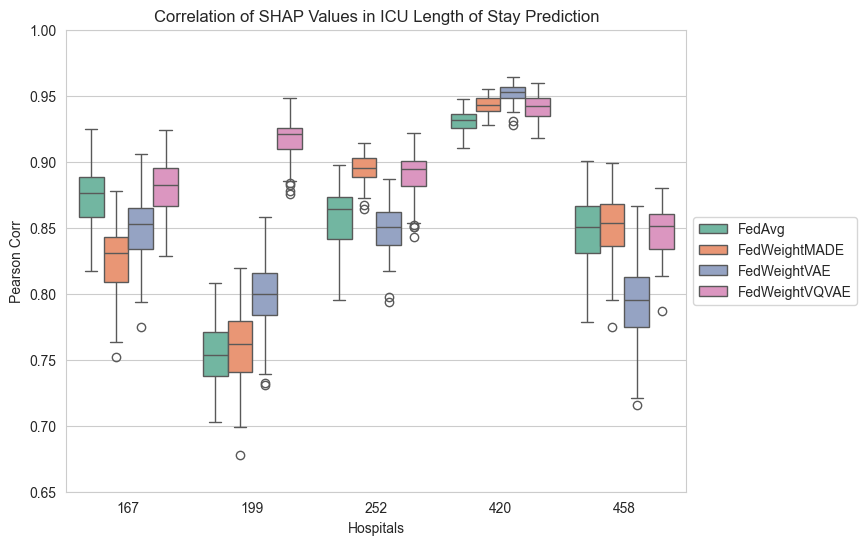

In [18]:
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.utils import resample

columns = ['Target', 'Algorithm', 'Pearson Corr']
df = pd.DataFrame(columns=columns)

total_seeds = 100
resampled_samples = 100

# Death
data_length_167 = len(length_shap_values_167_unweighted)

total_length_shap_values_167_unweighted_correlation = []
total_length_shap_values_167_made_correlation = []
total_length_shap_values_167_vae_correlation = []
total_length_shap_values_167_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_167 = resample(np.arange(data_length_167), n_samples=resampled_samples)
    length_shap_values_167_unweighted_sum = np.sum(length_shap_values_167_unweighted[resampled_ids_167], axis=0)
    length_shap_values_167_made_sum = np.sum(length_shap_values_167_made[resampled_ids_167], axis=0)
    length_shap_values_167_vae_sum = np.sum(length_shap_values_167_vae[resampled_ids_167], axis=0)
    length_shap_values_167_vqvae_sum = np.sum(length_shap_values_167_vqvae[resampled_ids_167], axis=0)
    length_shap_values_167_central_sum = np.sum(length_shap_values_167_central[resampled_ids_167], axis=0)

    length_shap_values_167_unweighted_correlation, _ = pearsonr(length_shap_values_167_unweighted_sum, length_shap_values_167_central_sum)
    length_shap_values_167_made_correlation, _ = pearsonr(length_shap_values_167_made_sum, length_shap_values_167_central_sum)
    length_shap_values_167_vae_correlation, _ = pearsonr(length_shap_values_167_vae_sum, length_shap_values_167_central_sum)
    length_shap_values_167_vqvae_correlation, _ = pearsonr(length_shap_values_167_vqvae_sum, length_shap_values_167_central_sum)

    total_length_shap_values_167_unweighted_correlation.append(length_shap_values_167_unweighted_correlation)
    total_length_shap_values_167_made_correlation.append(length_shap_values_167_made_correlation)
    total_length_shap_values_167_vae_correlation.append(length_shap_values_167_vae_correlation)
    total_length_shap_values_167_vqvae_correlation.append(length_shap_values_167_vqvae_correlation)

df_167_unweighted = create_df("Death", "167", "FedAvg", total_length_shap_values_167_unweighted_correlation, resampled_samples)
df_167_made = create_df("Death", "167", "FedWeightMADE", total_length_shap_values_167_made_correlation, resampled_samples)
df_167_vae = create_df("Death", "167", "FedWeightVAE", total_length_shap_values_167_vae_correlation, resampled_samples)
df_167_vqvae = create_df("Death", "167", "FedWeightVQVAE", total_length_shap_values_167_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_167_unweighted], ignore_index=True)
df = pd.concat([df, df_167_made], ignore_index=True)
df = pd.concat([df, df_167_vae], ignore_index=True)
df = pd.concat([df, df_167_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("167_p_value:")

_, total_length_167_unweighted_p_value = ranksums(total_length_shap_values_167_unweighted_correlation, total_length_shap_values_167_vae_correlation)
print(f"total_length_167_unweighted_p_value: {total_length_167_unweighted_p_value}")

_, total_length_167_vqvae_p_value = ranksums(total_length_shap_values_167_unweighted_correlation, total_length_shap_values_167_vqvae_correlation)
print(f"total_length_167_vqvae_p_value: {total_length_167_vqvae_p_value}")

_, total_length_167_made_p_value = ranksums(total_length_shap_values_167_unweighted_correlation, total_length_shap_values_167_made_correlation)
print(f"total_length_167_made_p_value: {total_length_167_made_p_value}")


data_length_199 = len(length_shap_values_199_unweighted)

total_length_shap_values_199_unweighted_correlation = []
total_length_shap_values_199_made_correlation = []
total_length_shap_values_199_vae_correlation = []
total_length_shap_values_199_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_199 = resample(np.arange(data_length_199), n_samples=resampled_samples)
    length_shap_values_199_unweighted_sum = np.sum(length_shap_values_199_unweighted[resampled_ids_199], axis=0)
    length_shap_values_199_made_sum = np.sum(length_shap_values_199_made[resampled_ids_199], axis=0)
    length_shap_values_199_vae_sum = np.sum(length_shap_values_199_vae[resampled_ids_199], axis=0)
    length_shap_values_199_vqvae_sum = np.sum(length_shap_values_199_vqvae[resampled_ids_199], axis=0)
    length_shap_values_199_central_sum = np.sum(length_shap_values_199_central[resampled_ids_199], axis=0)

    length_shap_values_199_unweighted_correlation, _ = pearsonr(length_shap_values_199_unweighted_sum, length_shap_values_199_central_sum)
    length_shap_values_199_made_correlation, _ = pearsonr(length_shap_values_199_made_sum, length_shap_values_199_central_sum)
    length_shap_values_199_vae_correlation, _ = pearsonr(length_shap_values_199_vae_sum, length_shap_values_199_central_sum)
    length_shap_values_199_vqvae_correlation, _ = pearsonr(length_shap_values_199_vqvae_sum, length_shap_values_199_central_sum)

    total_length_shap_values_199_unweighted_correlation.append(length_shap_values_199_unweighted_correlation)
    total_length_shap_values_199_made_correlation.append(length_shap_values_199_made_correlation)
    total_length_shap_values_199_vae_correlation.append(length_shap_values_199_vae_correlation)
    total_length_shap_values_199_vqvae_correlation.append(length_shap_values_199_vqvae_correlation)

df_199_unweighted = create_df("Death", "199", "FedAvg", total_length_shap_values_199_unweighted_correlation, resampled_samples)
df_199_made = create_df("Death", "199", "FedWeightMADE", total_length_shap_values_199_made_correlation, resampled_samples)
df_199_vae = create_df("Death", "199", "FedWeightVAE", total_length_shap_values_199_vae_correlation, resampled_samples)
df_199_vqvae = create_df("Death", "199", "FedWeightVQVAE", total_length_shap_values_199_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_199_unweighted], ignore_index=True)
df = pd.concat([df, df_199_made], ignore_index=True)
df = pd.concat([df, df_199_vae], ignore_index=True)
df = pd.concat([df, df_199_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("199_p_value:")

_, total_length_199_unweighted_p_value = ranksums(total_length_shap_values_199_unweighted_correlation, total_length_shap_values_199_vae_correlation)
print(f"total_length_199_unweighted_p_value: {total_length_199_unweighted_p_value}")

_, total_length_199_vqvae_p_value = ranksums(total_length_shap_values_199_unweighted_correlation, total_length_shap_values_199_vqvae_correlation)
print(f"total_length_199_vqvae_p_value: {total_length_199_vqvae_p_value}")

_, total_length_199_made_p_value = ranksums(total_length_shap_values_199_unweighted_correlation, total_length_shap_values_199_made_correlation)
print(f"total_length_199_made_p_value: {total_length_199_made_p_value}")

data_length_252 = len(length_shap_values_252_unweighted)

total_length_shap_values_252_unweighted_correlation = []
total_length_shap_values_252_made_correlation = []
total_length_shap_values_252_vae_correlation = []
total_length_shap_values_252_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_252 = resample(np.arange(data_length_252), n_samples=resampled_samples)
    length_shap_values_252_unweighted_sum = np.sum(length_shap_values_252_unweighted[resampled_ids_252], axis=0)
    length_shap_values_252_made_sum = np.sum(length_shap_values_252_made[resampled_ids_252], axis=0)
    length_shap_values_252_vae_sum = np.sum(length_shap_values_252_vae[resampled_ids_252], axis=0)
    length_shap_values_252_vqvae_sum = np.sum(length_shap_values_252_vqvae[resampled_ids_252], axis=0)
    length_shap_values_252_central_sum = np.sum(length_shap_values_252_central[resampled_ids_252], axis=0)

    length_shap_values_252_unweighted_correlation, _ = pearsonr(length_shap_values_252_unweighted_sum, length_shap_values_252_central_sum)
    length_shap_values_252_made_correlation, _ = pearsonr(length_shap_values_252_made_sum, length_shap_values_252_central_sum)
    length_shap_values_252_vae_correlation, _ = pearsonr(length_shap_values_252_vae_sum, length_shap_values_252_central_sum)
    length_shap_values_252_vqvae_correlation, _ = pearsonr(length_shap_values_252_vqvae_sum, length_shap_values_252_central_sum)

    total_length_shap_values_252_unweighted_correlation.append(length_shap_values_252_unweighted_correlation)
    total_length_shap_values_252_made_correlation.append(length_shap_values_252_made_correlation)
    total_length_shap_values_252_vae_correlation.append(length_shap_values_252_vae_correlation)
    total_length_shap_values_252_vqvae_correlation.append(length_shap_values_252_vqvae_correlation)

df_252_unweighted = create_df("Death", "252", "FedAvg", total_length_shap_values_252_unweighted_correlation, resampled_samples)
df_252_made = create_df("Death", "252", "FedWeightMADE", total_length_shap_values_252_made_correlation, resampled_samples)
df_252_vae = create_df("Death", "252", "FedWeightVAE", total_length_shap_values_252_vae_correlation, resampled_samples)
df_252_vqvae = create_df("Death", "252", "FedWeightVQVAE", total_length_shap_values_252_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_252_unweighted], ignore_index=True)
df = pd.concat([df, df_252_made], ignore_index=True)
df = pd.concat([df, df_252_vae], ignore_index=True)
df = pd.concat([df, df_252_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("252_p_value:")

_, total_length_252_unweighted_p_value = ranksums(total_length_shap_values_252_unweighted_correlation, total_length_shap_values_252_vae_correlation)
print(f"total_length_252_unweighted_p_value: {total_length_252_unweighted_p_value}")

_, total_length_252_vqvae_p_value = ranksums(total_length_shap_values_252_unweighted_correlation, total_length_shap_values_252_vqvae_correlation)
print(f"total_length_252_vqvae_p_value: {total_length_252_vqvae_p_value}")

_, total_length_252_made_p_value = ranksums(total_length_shap_values_252_unweighted_correlation, total_length_shap_values_252_made_correlation)
print(f"total_length_252_made_p_value: {total_length_252_made_p_value}")

data_length_420 = len(length_shap_values_420_unweighted)

total_length_shap_values_420_unweighted_correlation = []
total_length_shap_values_420_made_correlation = []
total_length_shap_values_420_vae_correlation = []
total_length_shap_values_420_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_420 = resample(np.arange(data_length_420), n_samples=resampled_samples)
    length_shap_values_420_unweighted_sum = np.sum(length_shap_values_420_unweighted[resampled_ids_420], axis=0)
    length_shap_values_420_made_sum = np.sum(length_shap_values_420_made[resampled_ids_420], axis=0)
    length_shap_values_420_vae_sum = np.sum(length_shap_values_420_vae[resampled_ids_420], axis=0)
    length_shap_values_420_vqvae_sum = np.sum(length_shap_values_420_vqvae[resampled_ids_420], axis=0)
    length_shap_values_420_central_sum = np.sum(length_shap_values_420_central[resampled_ids_420], axis=0)

    length_shap_values_420_unweighted_correlation, _ = pearsonr(length_shap_values_420_unweighted_sum, length_shap_values_420_central_sum)
    length_shap_values_420_made_correlation, _ = pearsonr(length_shap_values_420_made_sum, length_shap_values_420_central_sum)
    length_shap_values_420_vae_correlation, _ = pearsonr(length_shap_values_420_vae_sum, length_shap_values_420_central_sum)
    length_shap_values_420_vqvae_correlation, _ = pearsonr(length_shap_values_420_vqvae_sum, length_shap_values_420_central_sum)

    total_length_shap_values_420_unweighted_correlation.append(length_shap_values_420_unweighted_correlation)
    total_length_shap_values_420_made_correlation.append(length_shap_values_420_made_correlation)
    total_length_shap_values_420_vae_correlation.append(length_shap_values_420_vae_correlation)
    total_length_shap_values_420_vqvae_correlation.append(length_shap_values_420_vqvae_correlation)

df_420_unweighted = create_df("Death", "420", "FedAvg", total_length_shap_values_420_unweighted_correlation, resampled_samples)
df_420_made = create_df("Death", "420", "FedWeightMADE", total_length_shap_values_420_made_correlation, resampled_samples)
df_420_vae = create_df("Death", "420", "FedWeightVAE", total_length_shap_values_420_vae_correlation, resampled_samples)
df_420_vqvae = create_df("Death", "420", "FedWeightVQVAE", total_length_shap_values_420_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_420_unweighted], ignore_index=True)
df = pd.concat([df, df_420_made], ignore_index=True)
df = pd.concat([df, df_420_vae], ignore_index=True)
df = pd.concat([df, df_420_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("420_p_value:")

_, total_length_420_unweighted_p_value = ranksums(total_length_shap_values_420_unweighted_correlation, total_length_shap_values_420_vae_correlation)
print(f"total_length_420_unweighted_p_value: {total_length_420_unweighted_p_value}")

_, total_length_420_vqvae_p_value = ranksums(total_length_shap_values_420_unweighted_correlation, total_length_shap_values_420_vqvae_correlation)
print(f"total_length_420_vqvae_p_value: {total_length_420_vqvae_p_value}")

_, total_length_420_made_p_value = ranksums(total_length_shap_values_420_unweighted_correlation, total_length_shap_values_420_made_correlation)
print(f"total_length_420_made_p_value: {total_length_420_made_p_value}")

data_length_458 = len(length_shap_values_458_unweighted)

total_length_shap_values_458_unweighted_correlation = []
total_length_shap_values_458_made_correlation = []
total_length_shap_values_458_vae_correlation = []
total_length_shap_values_458_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_458 = resample(np.arange(data_length_458), n_samples=resampled_samples)
    length_shap_values_458_unweighted_sum = np.sum(length_shap_values_458_unweighted[resampled_ids_458], axis=0)
    length_shap_values_458_made_sum = np.sum(length_shap_values_458_made[resampled_ids_458], axis=0)
    length_shap_values_458_vae_sum = np.sum(length_shap_values_458_vae[resampled_ids_458], axis=0)
    length_shap_values_458_vqvae_sum = np.sum(length_shap_values_458_vqvae[resampled_ids_458], axis=0)
    length_shap_values_458_central_sum = np.sum(length_shap_values_458_central[resampled_ids_458], axis=0)

    length_shap_values_458_unweighted_correlation, _ = pearsonr(length_shap_values_458_unweighted_sum, length_shap_values_458_central_sum)
    length_shap_values_458_made_correlation, _ = pearsonr(length_shap_values_458_made_sum, length_shap_values_458_central_sum)
    length_shap_values_458_vae_correlation, _ = pearsonr(length_shap_values_458_vae_sum, length_shap_values_458_central_sum)
    length_shap_values_458_vqvae_correlation, _ = pearsonr(length_shap_values_458_vqvae_sum, length_shap_values_458_central_sum)

    total_length_shap_values_458_unweighted_correlation.append(length_shap_values_458_unweighted_correlation)
    total_length_shap_values_458_made_correlation.append(length_shap_values_458_made_correlation)
    total_length_shap_values_458_vae_correlation.append(length_shap_values_458_vae_correlation)
    total_length_shap_values_458_vqvae_correlation.append(length_shap_values_458_vqvae_correlation)

df_458_unweighted = create_df("Death", "458", "FedAvg", total_length_shap_values_458_unweighted_correlation, resampled_samples)
df_458_made = create_df("Death", "458", "FedWeightMADE", total_length_shap_values_458_made_correlation, resampled_samples)
df_458_vae = create_df("Death", "458", "FedWeightVAE", total_length_shap_values_458_vae_correlation, resampled_samples)
df_458_vqvae = create_df("Death", "458", "FedWeightVQVAE", total_length_shap_values_458_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_458_unweighted], ignore_index=True)
df = pd.concat([df, df_458_made], ignore_index=True)
df = pd.concat([df, df_458_vae], ignore_index=True)
df = pd.concat([df, df_458_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("458_p_value:")

_, total_length_458_unweighted_p_value = ranksums(total_length_shap_values_458_unweighted_correlation, total_length_shap_values_458_vae_correlation)
print(f"total_length_458_unweighted_p_value: {total_length_458_unweighted_p_value}")

_, total_length_458_vqvae_p_value = ranksums(total_length_shap_values_458_unweighted_correlation, total_length_shap_values_458_vqvae_correlation)
print(f"total_length_458_vqvae_p_value: {total_length_458_vqvae_p_value}")

_, total_length_458_made_p_value = ranksums(total_length_shap_values_458_unweighted_correlation, total_length_shap_values_458_made_correlation)
print(f"total_length_458_made_p_value: {total_length_458_made_p_value}")

sns.set_palette('Set2')
plt.figure(figsize=(8, 6))
plt.title("Correlation of SHAP Values in ICU Length of Stay Prediction")
ax = sns.boxplot(x = df['Target'],
                 y = df['Pearson Corr'],
                 hue = df['Algorithm'])
ax.set_ylabel('Pearson Corr')
ax.set_xlabel('Hospitals')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.65, 1.0)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


167_p_value:
total_death_167_unweighted_p_value: 0.05061717805231776
total_death_167_vqvae_p_value: 3.5617148746281386e-05
total_death_167_made_p_value: 0.18137488615771102
199_p_value:
total_death_199_unweighted_p_value: 2.5239394239903128e-34
total_death_199_vqvae_p_value: 8.609013798783542e-34
total_death_199_made_p_value: 0.07487480317825612
252_p_value:
total_death_252_unweighted_p_value: 6.050713492371496e-10
total_death_252_vqvae_p_value: 2.557200317861886e-10
total_death_252_made_p_value: 0.4969717991899737
420_p_value:
total_death_420_unweighted_p_value: 0.05178249447904373
total_death_420_vqvae_p_value: 0.42713640946700937
total_death_420_made_p_value: 0.0014786112628632992
458_p_value:
total_death_458_unweighted_p_value: 0.6904294112932212
total_death_458_vqvae_p_value: 0.6742934175257488
total_death_458_made_p_value: 0.8930970441733722


(0.915, 0.99)

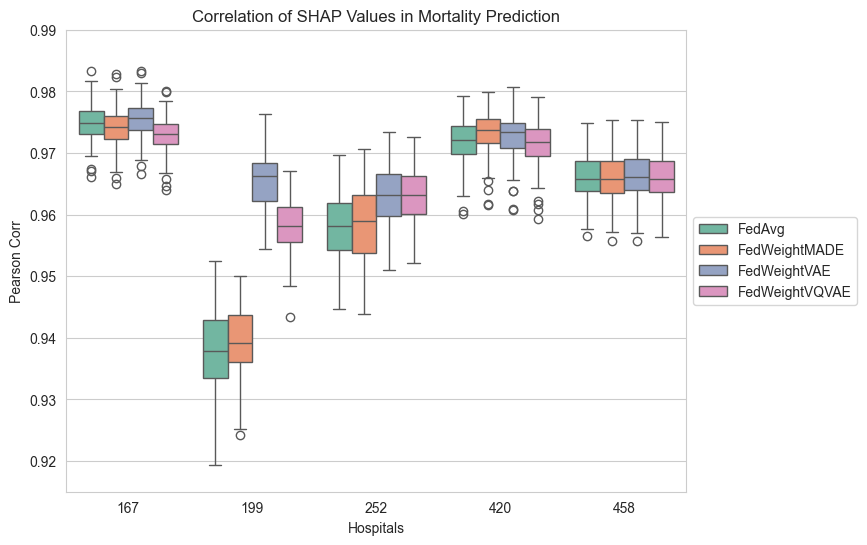

In [19]:
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.utils import resample

columns = ['Target', 'Algorithm', 'Pearson Corr']
df = pd.DataFrame(columns=columns)

total_seeds = 100
resampled_samples = 100

# Death
data_length_167 = len(death_shap_values_167_unweighted)

total_death_shap_values_167_unweighted_correlation = []
total_death_shap_values_167_made_correlation = []
total_death_shap_values_167_vae_correlation = []
total_death_shap_values_167_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_167 = resample(np.arange(data_length_167), n_samples=resampled_samples)
    death_shap_values_167_unweighted_sum = np.sum(death_shap_values_167_unweighted[resampled_ids_167], axis=0)
    death_shap_values_167_made_sum = np.sum(death_shap_values_167_made[resampled_ids_167], axis=0)
    death_shap_values_167_vae_sum = np.sum(death_shap_values_167_vae[resampled_ids_167], axis=0)
    death_shap_values_167_vqvae_sum = np.sum(death_shap_values_167_vqvae[resampled_ids_167], axis=0)
    death_shap_values_167_central_sum = np.sum(death_shap_values_167_central[resampled_ids_167], axis=0)

    death_shap_values_167_unweighted_correlation, _ = pearsonr(death_shap_values_167_unweighted_sum, death_shap_values_167_central_sum)
    death_shap_values_167_made_correlation, _ = pearsonr(death_shap_values_167_made_sum, death_shap_values_167_central_sum)
    death_shap_values_167_vae_correlation, _ = pearsonr(death_shap_values_167_vae_sum, death_shap_values_167_central_sum)
    death_shap_values_167_vqvae_correlation, _ = pearsonr(death_shap_values_167_vqvae_sum, death_shap_values_167_central_sum)

    total_death_shap_values_167_unweighted_correlation.append(death_shap_values_167_unweighted_correlation)
    total_death_shap_values_167_made_correlation.append(death_shap_values_167_made_correlation)
    total_death_shap_values_167_vae_correlation.append(death_shap_values_167_vae_correlation)
    total_death_shap_values_167_vqvae_correlation.append(death_shap_values_167_vqvae_correlation)

df_167_unweighted = create_df("Death", "167", "FedAvg", total_death_shap_values_167_unweighted_correlation, resampled_samples)
df_167_made = create_df("Death", "167", "FedWeightMADE", total_death_shap_values_167_made_correlation, resampled_samples)
df_167_vae = create_df("Death", "167", "FedWeightVAE", total_death_shap_values_167_vae_correlation, resampled_samples)
df_167_vqvae = create_df("Death", "167", "FedWeightVQVAE", total_death_shap_values_167_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_167_unweighted], ignore_index=True)
df = pd.concat([df, df_167_made], ignore_index=True)
df = pd.concat([df, df_167_vae], ignore_index=True)
df = pd.concat([df, df_167_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("167_p_value:")

_, total_death_167_unweighted_p_value = ranksums(total_death_shap_values_167_unweighted_correlation, total_death_shap_values_167_vae_correlation)
print(f"total_death_167_unweighted_p_value: {total_death_167_unweighted_p_value}")

_, total_death_167_vqvae_p_value = ranksums(total_death_shap_values_167_unweighted_correlation, total_death_shap_values_167_vqvae_correlation)
print(f"total_death_167_vqvae_p_value: {total_death_167_vqvae_p_value}")

_, total_death_167_made_p_value = ranksums(total_death_shap_values_167_unweighted_correlation, total_death_shap_values_167_made_correlation)
print(f"total_death_167_made_p_value: {total_death_167_made_p_value}")


data_length_199 = len(death_shap_values_199_unweighted)

total_death_shap_values_199_unweighted_correlation = []
total_death_shap_values_199_made_correlation = []
total_death_shap_values_199_vae_correlation = []
total_death_shap_values_199_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_199 = resample(np.arange(data_length_199), n_samples=resampled_samples)
    death_shap_values_199_unweighted_sum = np.sum(death_shap_values_199_unweighted[resampled_ids_199], axis=0)
    death_shap_values_199_made_sum = np.sum(death_shap_values_199_made[resampled_ids_199], axis=0)
    death_shap_values_199_vae_sum = np.sum(death_shap_values_199_vae[resampled_ids_199], axis=0)
    death_shap_values_199_vqvae_sum = np.sum(death_shap_values_199_vqvae[resampled_ids_199], axis=0)
    death_shap_values_199_central_sum = np.sum(death_shap_values_199_central[resampled_ids_199], axis=0)

    death_shap_values_199_unweighted_correlation, _ = pearsonr(death_shap_values_199_unweighted_sum, death_shap_values_199_central_sum)
    death_shap_values_199_made_correlation, _ = pearsonr(death_shap_values_199_made_sum, death_shap_values_199_central_sum)
    death_shap_values_199_vae_correlation, _ = pearsonr(death_shap_values_199_vae_sum, death_shap_values_199_central_sum)
    death_shap_values_199_vqvae_correlation, _ = pearsonr(death_shap_values_199_vqvae_sum, death_shap_values_199_central_sum)

    total_death_shap_values_199_unweighted_correlation.append(death_shap_values_199_unweighted_correlation)
    total_death_shap_values_199_made_correlation.append(death_shap_values_199_made_correlation)
    total_death_shap_values_199_vae_correlation.append(death_shap_values_199_vae_correlation)
    total_death_shap_values_199_vqvae_correlation.append(death_shap_values_199_vqvae_correlation)

df_199_unweighted = create_df("Death", "199", "FedAvg", total_death_shap_values_199_unweighted_correlation, resampled_samples)
df_199_made = create_df("Death", "199", "FedWeightMADE", total_death_shap_values_199_made_correlation, resampled_samples)
df_199_vae = create_df("Death", "199", "FedWeightVAE", total_death_shap_values_199_vae_correlation, resampled_samples)
df_199_vqvae = create_df("Death", "199", "FedWeightVQVAE", total_death_shap_values_199_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_199_unweighted], ignore_index=True)
df = pd.concat([df, df_199_made], ignore_index=True)
df = pd.concat([df, df_199_vae], ignore_index=True)
df = pd.concat([df, df_199_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("199_p_value:")

_, total_death_199_unweighted_p_value = ranksums(total_death_shap_values_199_unweighted_correlation, total_death_shap_values_199_vae_correlation)
print(f"total_death_199_unweighted_p_value: {total_death_199_unweighted_p_value}")

_, total_death_199_vqvae_p_value = ranksums(total_death_shap_values_199_unweighted_correlation, total_death_shap_values_199_vqvae_correlation)
print(f"total_death_199_vqvae_p_value: {total_death_199_vqvae_p_value}")

_, total_death_199_made_p_value = ranksums(total_death_shap_values_199_unweighted_correlation, total_death_shap_values_199_made_correlation)
print(f"total_death_199_made_p_value: {total_death_199_made_p_value}")

data_length_252 = len(death_shap_values_252_unweighted)

total_death_shap_values_252_unweighted_correlation = []
total_death_shap_values_252_made_correlation = []
total_death_shap_values_252_vae_correlation = []
total_death_shap_values_252_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_252 = resample(np.arange(data_length_252), n_samples=resampled_samples)
    death_shap_values_252_unweighted_sum = np.sum(death_shap_values_252_unweighted[resampled_ids_252], axis=0)
    death_shap_values_252_made_sum = np.sum(death_shap_values_252_made[resampled_ids_252], axis=0)
    death_shap_values_252_vae_sum = np.sum(death_shap_values_252_vae[resampled_ids_252], axis=0)
    death_shap_values_252_vqvae_sum = np.sum(death_shap_values_252_vqvae[resampled_ids_252], axis=0)
    death_shap_values_252_central_sum = np.sum(death_shap_values_252_central[resampled_ids_252], axis=0)

    death_shap_values_252_unweighted_correlation, _ = pearsonr(death_shap_values_252_unweighted_sum, death_shap_values_252_central_sum)
    death_shap_values_252_made_correlation, _ = pearsonr(death_shap_values_252_made_sum, death_shap_values_252_central_sum)
    death_shap_values_252_vae_correlation, _ = pearsonr(death_shap_values_252_vae_sum, death_shap_values_252_central_sum)
    death_shap_values_252_vqvae_correlation, _ = pearsonr(death_shap_values_252_vqvae_sum, death_shap_values_252_central_sum)

    total_death_shap_values_252_unweighted_correlation.append(death_shap_values_252_unweighted_correlation)
    total_death_shap_values_252_made_correlation.append(death_shap_values_252_made_correlation)
    total_death_shap_values_252_vae_correlation.append(death_shap_values_252_vae_correlation)
    total_death_shap_values_252_vqvae_correlation.append(death_shap_values_252_vqvae_correlation)

df_252_unweighted = create_df("Death", "252", "FedAvg", total_death_shap_values_252_unweighted_correlation, resampled_samples)
df_252_made = create_df("Death", "252", "FedWeightMADE", total_death_shap_values_252_made_correlation, resampled_samples)
df_252_vae = create_df("Death", "252", "FedWeightVAE", total_death_shap_values_252_vae_correlation, resampled_samples)
df_252_vqvae = create_df("Death", "252", "FedWeightVQVAE", total_death_shap_values_252_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_252_unweighted], ignore_index=True)
df = pd.concat([df, df_252_made], ignore_index=True)
df = pd.concat([df, df_252_vae], ignore_index=True)
df = pd.concat([df, df_252_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("252_p_value:")

_, total_death_252_unweighted_p_value = ranksums(total_death_shap_values_252_unweighted_correlation, total_death_shap_values_252_vae_correlation)
print(f"total_death_252_unweighted_p_value: {total_death_252_unweighted_p_value}")

_, total_death_252_vqvae_p_value = ranksums(total_death_shap_values_252_unweighted_correlation, total_death_shap_values_252_vqvae_correlation)
print(f"total_death_252_vqvae_p_value: {total_death_252_vqvae_p_value}")

_, total_death_252_made_p_value = ranksums(total_death_shap_values_252_unweighted_correlation, total_death_shap_values_252_made_correlation)
print(f"total_death_252_made_p_value: {total_death_252_made_p_value}")

data_length_420 = len(death_shap_values_420_unweighted)

total_death_shap_values_420_unweighted_correlation = []
total_death_shap_values_420_made_correlation = []
total_death_shap_values_420_vae_correlation = []
total_death_shap_values_420_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_420 = resample(np.arange(data_length_420), n_samples=resampled_samples)
    death_shap_values_420_unweighted_sum = np.sum(death_shap_values_420_unweighted[resampled_ids_420], axis=0)
    death_shap_values_420_made_sum = np.sum(death_shap_values_420_made[resampled_ids_420], axis=0)
    death_shap_values_420_vae_sum = np.sum(death_shap_values_420_vae[resampled_ids_420], axis=0)
    death_shap_values_420_vqvae_sum = np.sum(death_shap_values_420_vqvae[resampled_ids_420], axis=0)
    death_shap_values_420_central_sum = np.sum(death_shap_values_420_central[resampled_ids_420], axis=0)

    death_shap_values_420_unweighted_correlation, _ = pearsonr(death_shap_values_420_unweighted_sum, death_shap_values_420_central_sum)
    death_shap_values_420_made_correlation, _ = pearsonr(death_shap_values_420_made_sum, death_shap_values_420_central_sum)
    death_shap_values_420_vae_correlation, _ = pearsonr(death_shap_values_420_vae_sum, death_shap_values_420_central_sum)
    death_shap_values_420_vqvae_correlation, _ = pearsonr(death_shap_values_420_vqvae_sum, death_shap_values_420_central_sum)

    total_death_shap_values_420_unweighted_correlation.append(death_shap_values_420_unweighted_correlation)
    total_death_shap_values_420_made_correlation.append(death_shap_values_420_made_correlation)
    total_death_shap_values_420_vae_correlation.append(death_shap_values_420_vae_correlation)
    total_death_shap_values_420_vqvae_correlation.append(death_shap_values_420_vqvae_correlation)

df_420_unweighted = create_df("Death", "420", "FedAvg", total_death_shap_values_420_unweighted_correlation, resampled_samples)
df_420_made = create_df("Death", "420", "FedWeightMADE", total_death_shap_values_420_made_correlation, resampled_samples)
df_420_vae = create_df("Death", "420", "FedWeightVAE", total_death_shap_values_420_vae_correlation, resampled_samples)
df_420_vqvae = create_df("Death", "420", "FedWeightVQVAE", total_death_shap_values_420_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_420_unweighted], ignore_index=True)
df = pd.concat([df, df_420_made], ignore_index=True)
df = pd.concat([df, df_420_vae], ignore_index=True)
df = pd.concat([df, df_420_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("420_p_value:")

_, total_death_420_unweighted_p_value = ranksums(total_death_shap_values_420_unweighted_correlation, total_death_shap_values_420_vae_correlation)
print(f"total_death_420_unweighted_p_value: {total_death_420_unweighted_p_value}")

_, total_death_420_vqvae_p_value = ranksums(total_death_shap_values_420_unweighted_correlation, total_death_shap_values_420_vqvae_correlation)
print(f"total_death_420_vqvae_p_value: {total_death_420_vqvae_p_value}")

_, total_death_420_made_p_value = ranksums(total_death_shap_values_420_unweighted_correlation, total_death_shap_values_420_made_correlation)
print(f"total_death_420_made_p_value: {total_death_420_made_p_value}")

data_length_458 = len(death_shap_values_458_unweighted)

total_death_shap_values_458_unweighted_correlation = []
total_death_shap_values_458_made_correlation = []
total_death_shap_values_458_vae_correlation = []
total_death_shap_values_458_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_458 = resample(np.arange(data_length_458), n_samples=resampled_samples)
    death_shap_values_458_unweighted_sum = np.sum(death_shap_values_458_unweighted[resampled_ids_458], axis=0)
    death_shap_values_458_made_sum = np.sum(death_shap_values_458_made[resampled_ids_458], axis=0)
    death_shap_values_458_vae_sum = np.sum(death_shap_values_458_vae[resampled_ids_458], axis=0)
    death_shap_values_458_vqvae_sum = np.sum(death_shap_values_458_vqvae[resampled_ids_458], axis=0)
    death_shap_values_458_central_sum = np.sum(death_shap_values_458_central[resampled_ids_458], axis=0)

    death_shap_values_458_unweighted_correlation, _ = pearsonr(death_shap_values_458_unweighted_sum, death_shap_values_458_central_sum)
    death_shap_values_458_made_correlation, _ = pearsonr(death_shap_values_458_made_sum, death_shap_values_458_central_sum)
    death_shap_values_458_vae_correlation, _ = pearsonr(death_shap_values_458_vae_sum, death_shap_values_458_central_sum)
    death_shap_values_458_vqvae_correlation, _ = pearsonr(death_shap_values_458_vqvae_sum, death_shap_values_458_central_sum)

    total_death_shap_values_458_unweighted_correlation.append(death_shap_values_458_unweighted_correlation)
    total_death_shap_values_458_made_correlation.append(death_shap_values_458_made_correlation)
    total_death_shap_values_458_vae_correlation.append(death_shap_values_458_vae_correlation)
    total_death_shap_values_458_vqvae_correlation.append(death_shap_values_458_vqvae_correlation)

df_458_unweighted = create_df("Death", "458", "FedAvg", total_death_shap_values_458_unweighted_correlation, resampled_samples)
df_458_made = create_df("Death", "458", "FedWeightMADE", total_death_shap_values_458_made_correlation, resampled_samples)
df_458_vae = create_df("Death", "458", "FedWeightVAE", total_death_shap_values_458_vae_correlation, resampled_samples)
df_458_vqvae = create_df("Death", "458", "FedWeightVQVAE", total_death_shap_values_458_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_458_unweighted], ignore_index=True)
df = pd.concat([df, df_458_made], ignore_index=True)
df = pd.concat([df, df_458_vae], ignore_index=True)
df = pd.concat([df, df_458_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("458_p_value:")

_, total_death_458_unweighted_p_value = ranksums(total_death_shap_values_458_unweighted_correlation, total_death_shap_values_458_vae_correlation)
print(f"total_death_458_unweighted_p_value: {total_death_458_unweighted_p_value}")

_, total_death_458_vqvae_p_value = ranksums(total_death_shap_values_458_unweighted_correlation, total_death_shap_values_458_vqvae_correlation)
print(f"total_death_458_vqvae_p_value: {total_death_458_vqvae_p_value}")

_, total_death_458_made_p_value = ranksums(total_death_shap_values_458_unweighted_correlation, total_death_shap_values_458_made_correlation)
print(f"total_death_458_made_p_value: {total_death_458_made_p_value}")

sns.set_palette('Set2')
plt.figure(figsize=(8, 6))
plt.title("Correlation of SHAP Values in Mortality Prediction")
ax = sns.boxplot(x = df['Target'],
                 y = df['Pearson Corr'],
                 hue = df['Algorithm'])
ax.set_ylabel('Pearson Corr')
ax.set_xlabel('Hospitals')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.915, 0.99)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


167_p_value:
total_ventilator_167_unweighted_p_value: 3.4604583680028177e-09
total_ventilator_167_vqvae_p_value: 0.004385806012945045
total_ventilator_167_made_p_value: 0.00012877462607363538
199_p_value:
total_ventilator_199_unweighted_p_value: 2.44592245385329e-05
total_ventilator_199_vqvae_p_value: 0.0077379800256005314
total_ventilator_199_made_p_value: 5.2589854741234836e-05
252_p_value:
total_ventilator_252_unweighted_p_value: 1.6616503104692958e-09
total_ventilator_252_vqvae_p_value: 0.22554266552633795
total_ventilator_252_made_p_value: 0.01766669923887268
420_p_value:
total_ventilator_420_unweighted_p_value: 2.5239394239903128e-34
total_ventilator_420_vqvae_p_value: 4.202932144743563e-34
total_ventilator_420_made_p_value: 2.68023743241634e-34
458_p_value:
total_ventilator_458_unweighted_p_value: 6.144311040697244e-08
total_ventilator_458_vqvae_p_value: 1.1755445645416994e-15
total_ventilator_458_made_p_value: 0.042808931231833235


(0.915, 0.998)

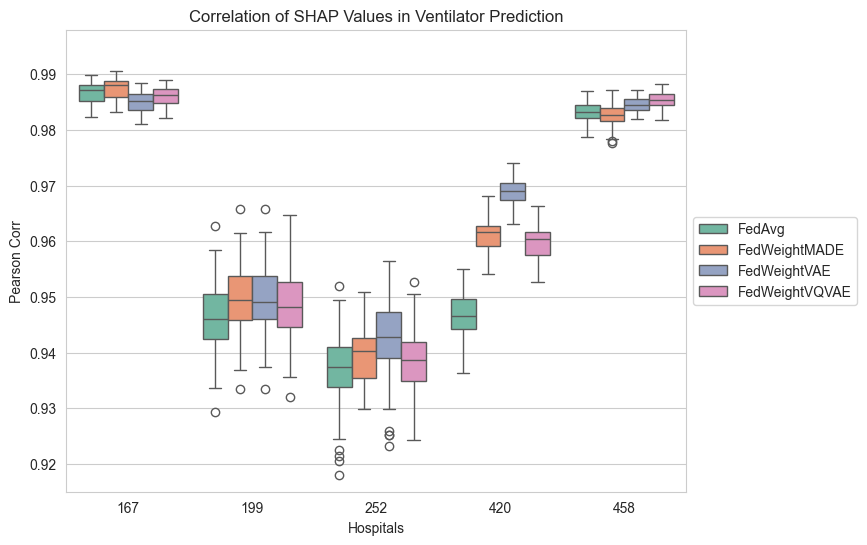

In [20]:
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.utils import resample

columns = ['Target', 'Algorithm', 'Pearson Corr']
df = pd.DataFrame(columns=columns)

total_seeds = 100
resampled_samples = 100

# Ventilator
data_length_167 = len(ventilator_shap_values_167_unweighted)

total_ventilator_shap_values_167_unweighted_correlation = []
total_ventilator_shap_values_167_made_correlation = []
total_ventilator_shap_values_167_vae_correlation = []
total_ventilator_shap_values_167_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_167 = resample(np.arange(data_length_167), n_samples=resampled_samples)
    ventilator_shap_values_167_unweighted_sum = np.sum(ventilator_shap_values_167_unweighted[resampled_ids_167], axis=0)
    ventilator_shap_values_167_made_sum = np.sum(ventilator_shap_values_167_made[resampled_ids_167], axis=0)
    ventilator_shap_values_167_vae_sum = np.sum(ventilator_shap_values_167_vae[resampled_ids_167], axis=0)
    ventilator_shap_values_167_vqvae_sum = np.sum(ventilator_shap_values_167_vqvae[resampled_ids_167], axis=0)
    ventilator_shap_values_167_central_sum = np.sum(ventilator_shap_values_167_central[resampled_ids_167], axis=0)

    ventilator_shap_values_167_unweighted_correlation, _ = pearsonr(ventilator_shap_values_167_unweighted_sum, ventilator_shap_values_167_central_sum)
    ventilator_shap_values_167_made_correlation, _ = pearsonr(ventilator_shap_values_167_made_sum, ventilator_shap_values_167_central_sum)
    ventilator_shap_values_167_vae_correlation, _ = pearsonr(ventilator_shap_values_167_vae_sum, ventilator_shap_values_167_central_sum)
    ventilator_shap_values_167_vqvae_correlation, _ = pearsonr(ventilator_shap_values_167_vqvae_sum, ventilator_shap_values_167_central_sum)

    total_ventilator_shap_values_167_unweighted_correlation.append(ventilator_shap_values_167_unweighted_correlation)
    total_ventilator_shap_values_167_made_correlation.append(ventilator_shap_values_167_made_correlation)
    total_ventilator_shap_values_167_vae_correlation.append(ventilator_shap_values_167_vae_correlation)
    total_ventilator_shap_values_167_vqvae_correlation.append(ventilator_shap_values_167_vqvae_correlation)

df_167_unweighted = create_df("Ventilator", "167", "FedAvg", total_ventilator_shap_values_167_unweighted_correlation, resampled_samples)
df_167_made = create_df("Ventilator", "167", "FedWeightMADE", total_ventilator_shap_values_167_made_correlation, resampled_samples)
df_167_vae = create_df("Ventilator", "167", "FedWeightVAE", total_ventilator_shap_values_167_vae_correlation, resampled_samples)
df_167_vqvae = create_df("Ventilator", "167", "FedWeightVQVAE", total_ventilator_shap_values_167_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_167_unweighted], ignore_index=True)
df = pd.concat([df, df_167_made], ignore_index=True)
df = pd.concat([df, df_167_vae], ignore_index=True)
df = pd.concat([df, df_167_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("167_p_value:")

_, total_ventilator_167_unweighted_p_value = ranksums(total_ventilator_shap_values_167_unweighted_correlation, total_ventilator_shap_values_167_vae_correlation)
print(f"total_ventilator_167_unweighted_p_value: {total_ventilator_167_unweighted_p_value}")

_, total_ventilator_167_vqvae_p_value = ranksums(total_ventilator_shap_values_167_unweighted_correlation, total_ventilator_shap_values_167_vqvae_correlation)
print(f"total_ventilator_167_vqvae_p_value: {total_ventilator_167_vqvae_p_value}")

_, total_ventilator_167_made_p_value = ranksums(total_ventilator_shap_values_167_unweighted_correlation, total_ventilator_shap_values_167_made_correlation)
print(f"total_ventilator_167_made_p_value: {total_ventilator_167_made_p_value}")


data_length_199 = len(ventilator_shap_values_199_unweighted)

total_ventilator_shap_values_199_unweighted_correlation = []
total_ventilator_shap_values_199_made_correlation = []
total_ventilator_shap_values_199_vae_correlation = []
total_ventilator_shap_values_199_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_199 = resample(np.arange(data_length_199), n_samples=resampled_samples)
    ventilator_shap_values_199_unweighted_sum = np.sum(ventilator_shap_values_199_unweighted[resampled_ids_199], axis=0)
    ventilator_shap_values_199_made_sum = np.sum(ventilator_shap_values_199_made[resampled_ids_199], axis=0)
    ventilator_shap_values_199_vae_sum = np.sum(ventilator_shap_values_199_vae[resampled_ids_199], axis=0)
    ventilator_shap_values_199_vqvae_sum = np.sum(ventilator_shap_values_199_vqvae[resampled_ids_199], axis=0)
    ventilator_shap_values_199_central_sum = np.sum(ventilator_shap_values_199_central[resampled_ids_199], axis=0)

    ventilator_shap_values_199_unweighted_correlation, _ = pearsonr(ventilator_shap_values_199_unweighted_sum, ventilator_shap_values_199_central_sum)
    ventilator_shap_values_199_made_correlation, _ = pearsonr(ventilator_shap_values_199_made_sum, ventilator_shap_values_199_central_sum)
    ventilator_shap_values_199_vae_correlation, _ = pearsonr(ventilator_shap_values_199_vae_sum, ventilator_shap_values_199_central_sum)
    ventilator_shap_values_199_vqvae_correlation, _ = pearsonr(ventilator_shap_values_199_vqvae_sum, ventilator_shap_values_199_central_sum)

    total_ventilator_shap_values_199_unweighted_correlation.append(ventilator_shap_values_199_unweighted_correlation)
    total_ventilator_shap_values_199_made_correlation.append(ventilator_shap_values_199_made_correlation)
    total_ventilator_shap_values_199_vae_correlation.append(ventilator_shap_values_199_vae_correlation)
    total_ventilator_shap_values_199_vqvae_correlation.append(ventilator_shap_values_199_vqvae_correlation)

df_199_unweighted = create_df("Ventilator", "199", "FedAvg", total_ventilator_shap_values_199_unweighted_correlation, resampled_samples)
df_199_made = create_df("Ventilator", "199", "FedWeightMADE", total_ventilator_shap_values_199_made_correlation, resampled_samples)
df_199_vae = create_df("Ventilator", "199", "FedWeightVAE", total_ventilator_shap_values_199_vae_correlation, resampled_samples)
df_199_vqvae = create_df("Ventilator", "199", "FedWeightVQVAE", total_ventilator_shap_values_199_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_199_unweighted], ignore_index=True)
df = pd.concat([df, df_199_made], ignore_index=True)
df = pd.concat([df, df_199_vae], ignore_index=True)
df = pd.concat([df, df_199_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("199_p_value:")

_, total_ventilator_199_unweighted_p_value = ranksums(total_ventilator_shap_values_199_unweighted_correlation, total_ventilator_shap_values_199_vae_correlation)
print(f"total_ventilator_199_unweighted_p_value: {total_ventilator_199_unweighted_p_value}")

_, total_ventilator_199_vqvae_p_value = ranksums(total_ventilator_shap_values_199_unweighted_correlation, total_ventilator_shap_values_199_vqvae_correlation)
print(f"total_ventilator_199_vqvae_p_value: {total_ventilator_199_vqvae_p_value}")

_, total_ventilator_199_made_p_value = ranksums(total_ventilator_shap_values_199_unweighted_correlation, total_ventilator_shap_values_199_made_correlation)
print(f"total_ventilator_199_made_p_value: {total_ventilator_199_made_p_value}")

data_length_252 = len(ventilator_shap_values_252_unweighted)

total_ventilator_shap_values_252_unweighted_correlation = []
total_ventilator_shap_values_252_made_correlation = []
total_ventilator_shap_values_252_vae_correlation = []
total_ventilator_shap_values_252_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_252 = resample(np.arange(data_length_252), n_samples=resampled_samples)
    ventilator_shap_values_252_unweighted_sum = np.sum(ventilator_shap_values_252_unweighted[resampled_ids_252], axis=0)
    ventilator_shap_values_252_made_sum = np.sum(ventilator_shap_values_252_made[resampled_ids_252], axis=0)
    ventilator_shap_values_252_vae_sum = np.sum(ventilator_shap_values_252_vae[resampled_ids_252], axis=0)
    ventilator_shap_values_252_vqvae_sum = np.sum(ventilator_shap_values_252_vqvae[resampled_ids_252], axis=0)
    ventilator_shap_values_252_central_sum = np.sum(ventilator_shap_values_252_central[resampled_ids_252], axis=0)

    ventilator_shap_values_252_unweighted_correlation, _ = pearsonr(ventilator_shap_values_252_unweighted_sum, ventilator_shap_values_252_central_sum)
    ventilator_shap_values_252_made_correlation, _ = pearsonr(ventilator_shap_values_252_made_sum, ventilator_shap_values_252_central_sum)
    ventilator_shap_values_252_vae_correlation, _ = pearsonr(ventilator_shap_values_252_vae_sum, ventilator_shap_values_252_central_sum)
    ventilator_shap_values_252_vqvae_correlation, _ = pearsonr(ventilator_shap_values_252_vqvae_sum, ventilator_shap_values_252_central_sum)

    total_ventilator_shap_values_252_unweighted_correlation.append(ventilator_shap_values_252_unweighted_correlation)
    total_ventilator_shap_values_252_made_correlation.append(ventilator_shap_values_252_made_correlation)
    total_ventilator_shap_values_252_vae_correlation.append(ventilator_shap_values_252_vae_correlation)
    total_ventilator_shap_values_252_vqvae_correlation.append(ventilator_shap_values_252_vqvae_correlation)

df_252_unweighted = create_df("Ventilator", "252", "FedAvg", total_ventilator_shap_values_252_unweighted_correlation, resampled_samples)
df_252_made = create_df("Ventilator", "252", "FedWeightMADE", total_ventilator_shap_values_252_made_correlation, resampled_samples)
df_252_vae = create_df("Ventilator", "252", "FedWeightVAE", total_ventilator_shap_values_252_vae_correlation, resampled_samples)
df_252_vqvae = create_df("Ventilator", "252", "FedWeightVQVAE", total_ventilator_shap_values_252_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_252_unweighted], ignore_index=True)
df = pd.concat([df, df_252_made], ignore_index=True)
df = pd.concat([df, df_252_vae], ignore_index=True)
df = pd.concat([df, df_252_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("252_p_value:")

_, total_ventilator_252_unweighted_p_value = ranksums(total_ventilator_shap_values_252_unweighted_correlation, total_ventilator_shap_values_252_vae_correlation)
print(f"total_ventilator_252_unweighted_p_value: {total_ventilator_252_unweighted_p_value}")

_, total_ventilator_252_vqvae_p_value = ranksums(total_ventilator_shap_values_252_unweighted_correlation, total_ventilator_shap_values_252_vqvae_correlation)
print(f"total_ventilator_252_vqvae_p_value: {total_ventilator_252_vqvae_p_value}")

_, total_ventilator_252_made_p_value = ranksums(total_ventilator_shap_values_252_unweighted_correlation, total_ventilator_shap_values_252_made_correlation)
print(f"total_ventilator_252_made_p_value: {total_ventilator_252_made_p_value}")

data_length_420 = len(ventilator_shap_values_420_unweighted)

total_ventilator_shap_values_420_unweighted_correlation = []
total_ventilator_shap_values_420_made_correlation = []
total_ventilator_shap_values_420_vae_correlation = []
total_ventilator_shap_values_420_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_420 = resample(np.arange(data_length_420), n_samples=resampled_samples)
    ventilator_shap_values_420_unweighted_sum = np.sum(ventilator_shap_values_420_unweighted[resampled_ids_420], axis=0)
    ventilator_shap_values_420_made_sum = np.sum(ventilator_shap_values_420_made[resampled_ids_420], axis=0)
    ventilator_shap_values_420_vae_sum = np.sum(ventilator_shap_values_420_vae[resampled_ids_420], axis=0)
    ventilator_shap_values_420_vqvae_sum = np.sum(ventilator_shap_values_420_vqvae[resampled_ids_420], axis=0)
    ventilator_shap_values_420_central_sum = np.sum(ventilator_shap_values_420_central[resampled_ids_420], axis=0)

    ventilator_shap_values_420_unweighted_correlation, _ = pearsonr(ventilator_shap_values_420_unweighted_sum, ventilator_shap_values_420_central_sum)
    ventilator_shap_values_420_made_correlation, _ = pearsonr(ventilator_shap_values_420_made_sum, ventilator_shap_values_420_central_sum)
    ventilator_shap_values_420_vae_correlation, _ = pearsonr(ventilator_shap_values_420_vae_sum, ventilator_shap_values_420_central_sum)
    ventilator_shap_values_420_vqvae_correlation, _ = pearsonr(ventilator_shap_values_420_vqvae_sum, ventilator_shap_values_420_central_sum)

    total_ventilator_shap_values_420_unweighted_correlation.append(ventilator_shap_values_420_unweighted_correlation)
    total_ventilator_shap_values_420_made_correlation.append(ventilator_shap_values_420_made_correlation)
    total_ventilator_shap_values_420_vae_correlation.append(ventilator_shap_values_420_vae_correlation)
    total_ventilator_shap_values_420_vqvae_correlation.append(ventilator_shap_values_420_vqvae_correlation)

df_420_unweighted = create_df("Ventilator", "420", "FedAvg", total_ventilator_shap_values_420_unweighted_correlation, resampled_samples)
df_420_made = create_df("Ventilator", "420", "FedWeightMADE", total_ventilator_shap_values_420_made_correlation, resampled_samples)
df_420_vae = create_df("Ventilator", "420", "FedWeightVAE", total_ventilator_shap_values_420_vae_correlation, resampled_samples)
df_420_vqvae = create_df("Ventilator", "420", "FedWeightVQVAE", total_ventilator_shap_values_420_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_420_unweighted], ignore_index=True)
df = pd.concat([df, df_420_made], ignore_index=True)
df = pd.concat([df, df_420_vae], ignore_index=True)
df = pd.concat([df, df_420_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("420_p_value:")

_, total_ventilator_420_unweighted_p_value = ranksums(total_ventilator_shap_values_420_unweighted_correlation, total_ventilator_shap_values_420_vae_correlation)
print(f"total_ventilator_420_unweighted_p_value: {total_ventilator_420_unweighted_p_value}")

_, total_ventilator_420_vqvae_p_value = ranksums(total_ventilator_shap_values_420_unweighted_correlation, total_ventilator_shap_values_420_vqvae_correlation)
print(f"total_ventilator_420_vqvae_p_value: {total_ventilator_420_vqvae_p_value}")

_, total_ventilator_420_made_p_value = ranksums(total_ventilator_shap_values_420_unweighted_correlation, total_ventilator_shap_values_420_made_correlation)
print(f"total_ventilator_420_made_p_value: {total_ventilator_420_made_p_value}")

data_length_458 = len(ventilator_shap_values_458_unweighted)

total_ventilator_shap_values_458_unweighted_correlation = []
total_ventilator_shap_values_458_made_correlation = []
total_ventilator_shap_values_458_vae_correlation = []
total_ventilator_shap_values_458_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_458 = resample(np.arange(data_length_458), n_samples=resampled_samples)
    ventilator_shap_values_458_unweighted_sum = np.sum(ventilator_shap_values_458_unweighted[resampled_ids_458], axis=0)
    ventilator_shap_values_458_made_sum = np.sum(ventilator_shap_values_458_made[resampled_ids_458], axis=0)
    ventilator_shap_values_458_vae_sum = np.sum(ventilator_shap_values_458_vae[resampled_ids_458], axis=0)
    ventilator_shap_values_458_vqvae_sum = np.sum(ventilator_shap_values_458_vqvae[resampled_ids_458], axis=0)
    ventilator_shap_values_458_central_sum = np.sum(ventilator_shap_values_458_central[resampled_ids_458], axis=0)

    ventilator_shap_values_458_unweighted_correlation, _ = pearsonr(ventilator_shap_values_458_unweighted_sum, ventilator_shap_values_458_central_sum)
    ventilator_shap_values_458_made_correlation, _ = pearsonr(ventilator_shap_values_458_made_sum, ventilator_shap_values_458_central_sum)
    ventilator_shap_values_458_vae_correlation, _ = pearsonr(ventilator_shap_values_458_vae_sum, ventilator_shap_values_458_central_sum)
    ventilator_shap_values_458_vqvae_correlation, _ = pearsonr(ventilator_shap_values_458_vqvae_sum, ventilator_shap_values_458_central_sum)

    total_ventilator_shap_values_458_unweighted_correlation.append(ventilator_shap_values_458_unweighted_correlation)
    total_ventilator_shap_values_458_made_correlation.append(ventilator_shap_values_458_made_correlation)
    total_ventilator_shap_values_458_vae_correlation.append(ventilator_shap_values_458_vae_correlation)
    total_ventilator_shap_values_458_vqvae_correlation.append(ventilator_shap_values_458_vqvae_correlation)

df_458_unweighted = create_df("Ventilator", "458", "FedAvg", total_ventilator_shap_values_458_unweighted_correlation, resampled_samples)
df_458_made = create_df("Ventilator", "458", "FedWeightMADE", total_ventilator_shap_values_458_made_correlation, resampled_samples)
df_458_vae = create_df("Ventilator", "458", "FedWeightVAE", total_ventilator_shap_values_458_vae_correlation, resampled_samples)
df_458_vqvae = create_df("Ventilator", "458", "FedWeightVQVAE", total_ventilator_shap_values_458_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_458_unweighted], ignore_index=True)
df = pd.concat([df, df_458_made], ignore_index=True)
df = pd.concat([df, df_458_vae], ignore_index=True)
df = pd.concat([df, df_458_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("458_p_value:")

_, total_ventilator_458_unweighted_p_value = ranksums(total_ventilator_shap_values_458_unweighted_correlation, total_ventilator_shap_values_458_vae_correlation)
print(f"total_ventilator_458_unweighted_p_value: {total_ventilator_458_unweighted_p_value}")

_, total_ventilator_458_vqvae_p_value = ranksums(total_ventilator_shap_values_458_unweighted_correlation, total_ventilator_shap_values_458_vqvae_correlation)
print(f"total_ventilator_458_vqvae_p_value: {total_ventilator_458_vqvae_p_value}")

_, total_ventilator_458_made_p_value = ranksums(total_ventilator_shap_values_458_unweighted_correlation, total_ventilator_shap_values_458_made_correlation)
print(f"total_ventilator_458_made_p_value: {total_ventilator_458_made_p_value}")

sns.set_palette('Set2')
plt.figure(figsize=(8, 6))
plt.title("Correlation of SHAP Values in Ventilator Prediction")
ax = sns.boxplot(x = df['Target'],
                 y = df['Pearson Corr'],
                 hue = df['Algorithm'])
ax.set_ylabel('Pearson Corr')
ax.set_xlabel('Hospitals')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.915, 0.998)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


167_p_value:
total_sepsis_167_unweighted_p_value: 8.398496618116238e-07
total_sepsis_167_vqvae_p_value: 0.12253461504294667
total_sepsis_167_made_p_value: 9.051531499421231e-07
199_p_value:
total_sepsis_199_unweighted_p_value: 4.157593231336253e-06
total_sepsis_199_vqvae_p_value: 0.20650579621363518
total_sepsis_199_made_p_value: 5.685143259827178e-07
252_p_value:
total_sepsis_252_unweighted_p_value: 1.5547405695034344e-07
total_sepsis_252_vqvae_p_value: 4.30940054440002e-05
total_sepsis_252_made_p_value: 0.020407182247406723
420_p_value:
total_sepsis_420_unweighted_p_value: 0.010014394248880279
total_sepsis_420_vqvae_p_value: 0.0036134068770961292
total_sepsis_420_made_p_value: 0.26206849787094544
458_p_value:
total_sepsis_458_unweighted_p_value: 0.0005025645607513888
total_sepsis_458_vqvae_p_value: 0.014550049247421997
total_sepsis_458_made_p_value: 6.852253630600128e-08


(0.981, 0.996)

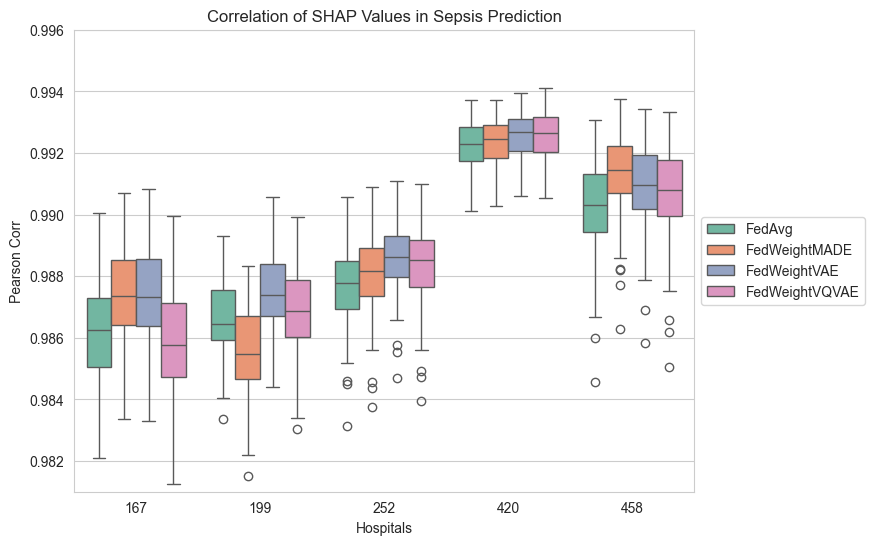

In [21]:
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.utils import resample

columns = ['Target', 'Algorithm', 'Pearson Corr']
df = pd.DataFrame(columns=columns)

total_seeds = 100
resampled_samples = 100

# Sepsis
data_length_167 = len(sepsis_shap_values_167_unweighted)

total_sepsis_shap_values_167_unweighted_correlation = []
total_sepsis_shap_values_167_made_correlation = []
total_sepsis_shap_values_167_vae_correlation = []
total_sepsis_shap_values_167_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_167 = resample(np.arange(data_length_167), n_samples=resampled_samples)
    sepsis_shap_values_167_unweighted_sum = np.sum(sepsis_shap_values_167_unweighted[resampled_ids_167], axis=0)
    sepsis_shap_values_167_made_sum = np.sum(sepsis_shap_values_167_made[resampled_ids_167], axis=0)
    sepsis_shap_values_167_vae_sum = np.sum(sepsis_shap_values_167_vae[resampled_ids_167], axis=0)
    sepsis_shap_values_167_vqvae_sum = np.sum(sepsis_shap_values_167_vqvae[resampled_ids_167], axis=0)
    sepsis_shap_values_167_central_sum = np.sum(sepsis_shap_values_167_central[resampled_ids_167], axis=0)

    sepsis_shap_values_167_unweighted_correlation, _ = pearsonr(sepsis_shap_values_167_unweighted_sum, sepsis_shap_values_167_central_sum)
    sepsis_shap_values_167_made_correlation, _ = pearsonr(sepsis_shap_values_167_made_sum, sepsis_shap_values_167_central_sum)
    sepsis_shap_values_167_vae_correlation, _ = pearsonr(sepsis_shap_values_167_vae_sum, sepsis_shap_values_167_central_sum)
    sepsis_shap_values_167_vqvae_correlation, _ = pearsonr(sepsis_shap_values_167_vqvae_sum, sepsis_shap_values_167_central_sum)

    total_sepsis_shap_values_167_unweighted_correlation.append(sepsis_shap_values_167_unweighted_correlation)
    total_sepsis_shap_values_167_made_correlation.append(sepsis_shap_values_167_made_correlation)
    total_sepsis_shap_values_167_vae_correlation.append(sepsis_shap_values_167_vae_correlation)
    total_sepsis_shap_values_167_vqvae_correlation.append(sepsis_shap_values_167_vqvae_correlation)

df_167_unweighted = create_df("Sepsis", "167", "FedAvg", total_sepsis_shap_values_167_unweighted_correlation, resampled_samples)
df_167_made = create_df("Sepsis", "167", "FedWeightMADE", total_sepsis_shap_values_167_made_correlation, resampled_samples)
df_167_vae = create_df("Sepsis", "167", "FedWeightVAE", total_sepsis_shap_values_167_vae_correlation, resampled_samples)
df_167_vqvae = create_df("Sepsis", "167", "FedWeightVQVAE", total_sepsis_shap_values_167_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_167_unweighted], ignore_index=True)
df = pd.concat([df, df_167_made], ignore_index=True)
df = pd.concat([df, df_167_vae], ignore_index=True)
df = pd.concat([df, df_167_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("167_p_value:")

_, total_sepsis_167_unweighted_p_value = ranksums(total_sepsis_shap_values_167_unweighted_correlation, total_sepsis_shap_values_167_vae_correlation)
print(f"total_sepsis_167_unweighted_p_value: {total_sepsis_167_unweighted_p_value}")

_, total_sepsis_167_vqvae_p_value = ranksums(total_sepsis_shap_values_167_unweighted_correlation, total_sepsis_shap_values_167_vqvae_correlation)
print(f"total_sepsis_167_vqvae_p_value: {total_sepsis_167_vqvae_p_value}")

_, total_sepsis_167_made_p_value = ranksums(total_sepsis_shap_values_167_unweighted_correlation, total_sepsis_shap_values_167_made_correlation)
print(f"total_sepsis_167_made_p_value: {total_sepsis_167_made_p_value}")


data_length_199 = len(sepsis_shap_values_199_unweighted)

total_sepsis_shap_values_199_unweighted_correlation = []
total_sepsis_shap_values_199_made_correlation = []
total_sepsis_shap_values_199_vae_correlation = []
total_sepsis_shap_values_199_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_199 = resample(np.arange(data_length_199), n_samples=resampled_samples)
    sepsis_shap_values_199_unweighted_sum = np.sum(sepsis_shap_values_199_unweighted[resampled_ids_199], axis=0)
    sepsis_shap_values_199_made_sum = np.sum(sepsis_shap_values_199_made[resampled_ids_199], axis=0)
    sepsis_shap_values_199_vae_sum = np.sum(sepsis_shap_values_199_vae[resampled_ids_199], axis=0)
    sepsis_shap_values_199_vqvae_sum = np.sum(sepsis_shap_values_199_vqvae[resampled_ids_199], axis=0)
    sepsis_shap_values_199_central_sum = np.sum(sepsis_shap_values_199_central[resampled_ids_199], axis=0)

    sepsis_shap_values_199_unweighted_correlation, _ = pearsonr(sepsis_shap_values_199_unweighted_sum, sepsis_shap_values_199_central_sum)
    sepsis_shap_values_199_made_correlation, _ = pearsonr(sepsis_shap_values_199_made_sum, sepsis_shap_values_199_central_sum)
    sepsis_shap_values_199_vae_correlation, _ = pearsonr(sepsis_shap_values_199_vae_sum, sepsis_shap_values_199_central_sum)
    sepsis_shap_values_199_vqvae_correlation, _ = pearsonr(sepsis_shap_values_199_vqvae_sum, sepsis_shap_values_199_central_sum)

    total_sepsis_shap_values_199_unweighted_correlation.append(sepsis_shap_values_199_unweighted_correlation)
    total_sepsis_shap_values_199_made_correlation.append(sepsis_shap_values_199_made_correlation)
    total_sepsis_shap_values_199_vae_correlation.append(sepsis_shap_values_199_vae_correlation)
    total_sepsis_shap_values_199_vqvae_correlation.append(sepsis_shap_values_199_vqvae_correlation)

df_199_unweighted = create_df("Sepsis", "199", "FedAvg", total_sepsis_shap_values_199_unweighted_correlation, resampled_samples)
df_199_made = create_df("Sepsis", "199", "FedWeightMADE", total_sepsis_shap_values_199_made_correlation, resampled_samples)
df_199_vae = create_df("Sepsis", "199", "FedWeightVAE", total_sepsis_shap_values_199_vae_correlation, resampled_samples)
df_199_vqvae = create_df("Sepsis", "199", "FedWeightVQVAE", total_sepsis_shap_values_199_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_199_unweighted], ignore_index=True)
df = pd.concat([df, df_199_made], ignore_index=True)
df = pd.concat([df, df_199_vae], ignore_index=True)
df = pd.concat([df, df_199_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("199_p_value:")

_, total_sepsis_199_unweighted_p_value = ranksums(total_sepsis_shap_values_199_unweighted_correlation, total_sepsis_shap_values_199_vae_correlation)
print(f"total_sepsis_199_unweighted_p_value: {total_sepsis_199_unweighted_p_value}")

_, total_sepsis_199_vqvae_p_value = ranksums(total_sepsis_shap_values_199_unweighted_correlation, total_sepsis_shap_values_199_vqvae_correlation)
print(f"total_sepsis_199_vqvae_p_value: {total_sepsis_199_vqvae_p_value}")

_, total_sepsis_199_made_p_value = ranksums(total_sepsis_shap_values_199_unweighted_correlation, total_sepsis_shap_values_199_made_correlation)
print(f"total_sepsis_199_made_p_value: {total_sepsis_199_made_p_value}")

data_length_252 = len(sepsis_shap_values_252_unweighted)

total_sepsis_shap_values_252_unweighted_correlation = []
total_sepsis_shap_values_252_made_correlation = []
total_sepsis_shap_values_252_vae_correlation = []
total_sepsis_shap_values_252_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_252 = resample(np.arange(data_length_252), n_samples=resampled_samples)
    sepsis_shap_values_252_unweighted_sum = np.sum(sepsis_shap_values_252_unweighted[resampled_ids_252], axis=0)
    sepsis_shap_values_252_made_sum = np.sum(sepsis_shap_values_252_made[resampled_ids_252], axis=0)
    sepsis_shap_values_252_vae_sum = np.sum(sepsis_shap_values_252_vae[resampled_ids_252], axis=0)
    sepsis_shap_values_252_vqvae_sum = np.sum(sepsis_shap_values_252_vqvae[resampled_ids_252], axis=0)
    sepsis_shap_values_252_central_sum = np.sum(sepsis_shap_values_252_central[resampled_ids_252], axis=0)

    sepsis_shap_values_252_unweighted_correlation, _ = pearsonr(sepsis_shap_values_252_unweighted_sum, sepsis_shap_values_252_central_sum)
    sepsis_shap_values_252_made_correlation, _ = pearsonr(sepsis_shap_values_252_made_sum, sepsis_shap_values_252_central_sum)
    sepsis_shap_values_252_vae_correlation, _ = pearsonr(sepsis_shap_values_252_vae_sum, sepsis_shap_values_252_central_sum)
    sepsis_shap_values_252_vqvae_correlation, _ = pearsonr(sepsis_shap_values_252_vqvae_sum, sepsis_shap_values_252_central_sum)

    total_sepsis_shap_values_252_unweighted_correlation.append(sepsis_shap_values_252_unweighted_correlation)
    total_sepsis_shap_values_252_made_correlation.append(sepsis_shap_values_252_made_correlation)
    total_sepsis_shap_values_252_vae_correlation.append(sepsis_shap_values_252_vae_correlation)
    total_sepsis_shap_values_252_vqvae_correlation.append(sepsis_shap_values_252_vqvae_correlation)

df_252_unweighted = create_df("Sepsis", "252", "FedAvg", total_sepsis_shap_values_252_unweighted_correlation, resampled_samples)
df_252_made = create_df("Sepsis", "252", "FedWeightMADE", total_sepsis_shap_values_252_made_correlation, resampled_samples)
df_252_vae = create_df("Sepsis", "252", "FedWeightVAE", total_sepsis_shap_values_252_vae_correlation, resampled_samples)
df_252_vqvae = create_df("Sepsis", "252", "FedWeightVQVAE", total_sepsis_shap_values_252_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_252_unweighted], ignore_index=True)
df = pd.concat([df, df_252_made], ignore_index=True)
df = pd.concat([df, df_252_vae], ignore_index=True)
df = pd.concat([df, df_252_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("252_p_value:")

_, total_sepsis_252_unweighted_p_value = ranksums(total_sepsis_shap_values_252_unweighted_correlation, total_sepsis_shap_values_252_vae_correlation)
print(f"total_sepsis_252_unweighted_p_value: {total_sepsis_252_unweighted_p_value}")

_, total_sepsis_252_vqvae_p_value = ranksums(total_sepsis_shap_values_252_unweighted_correlation, total_sepsis_shap_values_252_vqvae_correlation)
print(f"total_sepsis_252_vqvae_p_value: {total_sepsis_252_vqvae_p_value}")

_, total_sepsis_252_made_p_value = ranksums(total_sepsis_shap_values_252_unweighted_correlation, total_sepsis_shap_values_252_made_correlation)
print(f"total_sepsis_252_made_p_value: {total_sepsis_252_made_p_value}")

data_length_420 = len(sepsis_shap_values_420_unweighted)

total_sepsis_shap_values_420_unweighted_correlation = []
total_sepsis_shap_values_420_made_correlation = []
total_sepsis_shap_values_420_vae_correlation = []
total_sepsis_shap_values_420_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_420 = resample(np.arange(data_length_420), n_samples=resampled_samples)
    sepsis_shap_values_420_unweighted_sum = np.sum(sepsis_shap_values_420_unweighted[resampled_ids_420], axis=0)
    sepsis_shap_values_420_made_sum = np.sum(sepsis_shap_values_420_made[resampled_ids_420], axis=0)
    sepsis_shap_values_420_vae_sum = np.sum(sepsis_shap_values_420_vae[resampled_ids_420], axis=0)
    sepsis_shap_values_420_vqvae_sum = np.sum(sepsis_shap_values_420_vqvae[resampled_ids_420], axis=0)
    sepsis_shap_values_420_central_sum = np.sum(sepsis_shap_values_420_central[resampled_ids_420], axis=0)

    sepsis_shap_values_420_unweighted_correlation, _ = pearsonr(sepsis_shap_values_420_unweighted_sum, sepsis_shap_values_420_central_sum)
    sepsis_shap_values_420_made_correlation, _ = pearsonr(sepsis_shap_values_420_made_sum, sepsis_shap_values_420_central_sum)
    sepsis_shap_values_420_vae_correlation, _ = pearsonr(sepsis_shap_values_420_vae_sum, sepsis_shap_values_420_central_sum)
    sepsis_shap_values_420_vqvae_correlation, _ = pearsonr(sepsis_shap_values_420_vqvae_sum, sepsis_shap_values_420_central_sum)

    total_sepsis_shap_values_420_unweighted_correlation.append(sepsis_shap_values_420_unweighted_correlation)
    total_sepsis_shap_values_420_made_correlation.append(sepsis_shap_values_420_made_correlation)
    total_sepsis_shap_values_420_vae_correlation.append(sepsis_shap_values_420_vae_correlation)
    total_sepsis_shap_values_420_vqvae_correlation.append(sepsis_shap_values_420_vqvae_correlation)

df_420_unweighted = create_df("Sepsis", "420", "FedAvg", total_sepsis_shap_values_420_unweighted_correlation, resampled_samples)
df_420_made = create_df("Sepsis", "420", "FedWeightMADE", total_sepsis_shap_values_420_made_correlation, resampled_samples)
df_420_vae = create_df("Sepsis", "420", "FedWeightVAE", total_sepsis_shap_values_420_vae_correlation, resampled_samples)
df_420_vqvae = create_df("Sepsis", "420", "FedWeightVQVAE", total_sepsis_shap_values_420_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_420_unweighted], ignore_index=True)
df = pd.concat([df, df_420_made], ignore_index=True)
df = pd.concat([df, df_420_vae], ignore_index=True)
df = pd.concat([df, df_420_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("420_p_value:")

_, total_sepsis_420_unweighted_p_value = ranksums(total_sepsis_shap_values_420_unweighted_correlation, total_sepsis_shap_values_420_vae_correlation)
print(f"total_sepsis_420_unweighted_p_value: {total_sepsis_420_unweighted_p_value}")

_, total_sepsis_420_vqvae_p_value = ranksums(total_sepsis_shap_values_420_unweighted_correlation, total_sepsis_shap_values_420_vqvae_correlation)
print(f"total_sepsis_420_vqvae_p_value: {total_sepsis_420_vqvae_p_value}")

_, total_sepsis_420_made_p_value = ranksums(total_sepsis_shap_values_420_unweighted_correlation, total_sepsis_shap_values_420_made_correlation)
print(f"total_sepsis_420_made_p_value: {total_sepsis_420_made_p_value}")

data_length_458 = len(sepsis_shap_values_458_unweighted)

total_sepsis_shap_values_458_unweighted_correlation = []
total_sepsis_shap_values_458_made_correlation = []
total_sepsis_shap_values_458_vae_correlation = []
total_sepsis_shap_values_458_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_458 = resample(np.arange(data_length_458), n_samples=resampled_samples)
    sepsis_shap_values_458_unweighted_sum = np.sum(sepsis_shap_values_458_unweighted[resampled_ids_458], axis=0)
    sepsis_shap_values_458_made_sum = np.sum(sepsis_shap_values_458_made[resampled_ids_458], axis=0)
    sepsis_shap_values_458_vae_sum = np.sum(sepsis_shap_values_458_vae[resampled_ids_458], axis=0)
    sepsis_shap_values_458_vqvae_sum = np.sum(sepsis_shap_values_458_vqvae[resampled_ids_458], axis=0)
    sepsis_shap_values_458_central_sum = np.sum(sepsis_shap_values_458_central[resampled_ids_458], axis=0)

    sepsis_shap_values_458_unweighted_correlation, _ = pearsonr(sepsis_shap_values_458_unweighted_sum, sepsis_shap_values_458_central_sum)
    sepsis_shap_values_458_made_correlation, _ = pearsonr(sepsis_shap_values_458_made_sum, sepsis_shap_values_458_central_sum)
    sepsis_shap_values_458_vae_correlation, _ = pearsonr(sepsis_shap_values_458_vae_sum, sepsis_shap_values_458_central_sum)
    sepsis_shap_values_458_vqvae_correlation, _ = pearsonr(sepsis_shap_values_458_vqvae_sum, sepsis_shap_values_458_central_sum)

    total_sepsis_shap_values_458_unweighted_correlation.append(sepsis_shap_values_458_unweighted_correlation)
    total_sepsis_shap_values_458_made_correlation.append(sepsis_shap_values_458_made_correlation)
    total_sepsis_shap_values_458_vae_correlation.append(sepsis_shap_values_458_vae_correlation)
    total_sepsis_shap_values_458_vqvae_correlation.append(sepsis_shap_values_458_vqvae_correlation)

df_458_unweighted = create_df("Sepsis", "458", "FedAvg", total_sepsis_shap_values_458_unweighted_correlation, resampled_samples)
df_458_made = create_df("Sepsis", "458", "FedWeightMADE", total_sepsis_shap_values_458_made_correlation, resampled_samples)
df_458_vae = create_df("Sepsis", "458", "FedWeightVAE", total_sepsis_shap_values_458_vae_correlation, resampled_samples)
df_458_vqvae = create_df("Sepsis", "458", "FedWeightVQVAE", total_sepsis_shap_values_458_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_458_unweighted], ignore_index=True)
df = pd.concat([df, df_458_made], ignore_index=True)
df = pd.concat([df, df_458_vae], ignore_index=True)
df = pd.concat([df, df_458_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("458_p_value:")

_, total_sepsis_458_unweighted_p_value = ranksums(total_sepsis_shap_values_458_unweighted_correlation, total_sepsis_shap_values_458_vae_correlation)
print(f"total_sepsis_458_unweighted_p_value: {total_sepsis_458_unweighted_p_value}")

_, total_sepsis_458_vqvae_p_value = ranksums(total_sepsis_shap_values_458_unweighted_correlation, total_sepsis_shap_values_458_vqvae_correlation)
print(f"total_sepsis_458_vqvae_p_value: {total_sepsis_458_vqvae_p_value}")

_, total_sepsis_458_made_p_value = ranksums(total_sepsis_shap_values_458_unweighted_correlation, total_sepsis_shap_values_458_made_correlation)
print(f"total_sepsis_458_made_p_value: {total_sepsis_458_made_p_value}")

sns.set_palette('Set2')
plt.figure(figsize=(8, 6))
plt.title("Correlation of SHAP Values in Sepsis Prediction")
ax = sns.boxplot(x = df['Target'],
                 y = df['Pearson Corr'],
                 hue = df['Algorithm'])
ax.set_ylabel('Pearson Corr')
ax.set_xlabel('Hospitals')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.981, 0.996)

## MIMIC

In [22]:
import shap

""" mimic """
print("MADE")
death_model_mimic_made = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_mimic_made = eICULSTM(268)
sepsis_model_mimic_made = eICULSTM(268)
length_model_mimic_made = ModelBinaryClassification(268, "16", 0.85)

death_model_mimic_made.load_state_dict(torch.load("../data/death_time/PID: 8609187e-4312-43e2-aa3c-cbfe54fdcfb6 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_mimic_made.load_state_dict(torch.load("../data/ventilator_time/PID: 50f9f384-c1cd-4c81-978b-0d9413bbe3e2 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_mimic_made.load_state_dict(torch.load("../data/sepsis_time/PID: b32d56bf-0156-4222-8efb-728e041d0fa2 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_mimic_made.load_state_dict(torch.load("../data/length_time/PID: e13b311d-636b-47cc-877b-be5fbf007365 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_mimic_made = shap.GradientExplainer(length_model_mimic_made, x_target_test_mimic)
length_shap_values_mimic_made = length_explainer_mimic_made.shap_values(x_target_test_mimic)
length_shap_values_mimic_made = length_shap_values_mimic_made * x_target_test_mimic.detach().numpy()

# Death
death_explainer_mimic_made = shap.GradientExplainer(death_model_mimic_made, x_target_test_mimic)
death_shap_values_mimic_made = death_explainer_mimic_made.shap_values(x_target_test_mimic)
death_shap_values_mimic_made = death_shap_values_mimic_made * x_target_test_mimic.detach().numpy()

# Ventilator
ventilator_explainer_mimic_made = shap.GradientExplainer(ventilator_model_mimic_made, x_target_test_time_mimic)
ventilator_shap_values_mimic_made = ventilator_explainer_mimic_made.shap_values(x_target_test_time_mimic)
ventilator_shap_values_mimic_made = sum_time_shap_values(ventilator_shap_values_mimic_made, x_target_test_time_mimic)

# Sepsis
sepsis_explainer_mimic_made = shap.GradientExplainer(sepsis_model_mimic_made, x_target_test_time_mimic)
sepsis_shap_values_mimic_made = sepsis_explainer_mimic_made.shap_values(x_target_test_time_mimic)
sepsis_shap_values_mimic_made = sum_time_shap_values(sepsis_shap_values_mimic_made, x_target_test_time_mimic)


""" mimic """
print("VAE")
death_model_mimic_vae = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_mimic_vae = eICULSTM(268)
sepsis_model_mimic_vae = eICULSTM(268)
length_model_mimic_vae = ModelBinaryClassification(268, "16", 0.85)

death_model_mimic_vae.load_state_dict(torch.load("../data/death_time/PID: ef85b55c-c870-42d0-b504-fa3d4ab85fd8 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_mimic_vae.load_state_dict(torch.load("../data/ventilator_time/PID: ff30e0d7-1b47-4351-aa9f-d0751767ec2d - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_mimic_vae.load_state_dict(torch.load("../data/sepsis_time/PID: 1e85a8ad-9528-49af-89ee-b9471f133a08 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_mimic_vae.load_state_dict(torch.load("../data/length_time/PID: 8f419f76-ad2f-4886-a595-3079cc404645 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_mimic_vae = shap.GradientExplainer(length_model_mimic_vae, x_target_test_mimic)
length_shap_values_mimic_vae = length_explainer_mimic_vae.shap_values(x_target_test_mimic)
length_shap_values_mimic_vae = length_shap_values_mimic_vae * x_target_test_mimic.detach().numpy()

# Death
death_explainer_mimic_vae = shap.GradientExplainer(death_model_mimic_vae, x_target_test_mimic)
death_shap_values_mimic_vae = death_explainer_mimic_vae.shap_values(x_target_test_mimic)
death_shap_values_mimic_vae = death_shap_values_mimic_vae * x_target_test_mimic.detach().numpy()

# Ventilator
ventilator_explainer_mimic_vae = shap.GradientExplainer(ventilator_model_mimic_vae, x_target_test_time_mimic)
ventilator_shap_values_mimic_vae = ventilator_explainer_mimic_vae.shap_values(x_target_test_time_mimic)
ventilator_shap_values_mimic_vae = sum_time_shap_values(ventilator_shap_values_mimic_vae, x_target_test_time_mimic)

# Sepsis
sepsis_explainer_mimic_vae = shap.GradientExplainer(sepsis_model_mimic_vae, x_target_test_time_mimic)
sepsis_shap_values_mimic_vae = sepsis_explainer_mimic_vae.shap_values(x_target_test_time_mimic)
sepsis_shap_values_mimic_vae = sum_time_shap_values(sepsis_shap_values_mimic_vae, x_target_test_time_mimic)

import shap

""" mimic """
print("VQVAE")
death_model_mimic_vqvae = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_mimic_vqvae = eICULSTM(268)
sepsis_model_mimic_vqvae = eICULSTM(268)
length_model_mimic_vqvae = ModelBinaryClassification(268, "16", 0.85)

death_model_mimic_vqvae.load_state_dict(torch.load("../data/death_time/PID: bebde882-25ea-4d22-8bab-cd3042695697 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_mimic_vqvae.load_state_dict(torch.load("../data/ventilator_time/PID: 03463b3b-5ab2-4d44-b9ee-6b27bb5fd7cb - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_mimic_vqvae.load_state_dict(torch.load("../data/sepsis_time/PID: 933e21f6-b7af-49f0-b9ae-a8ddad81fbbb - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_mimic_vqvae.load_state_dict(torch.load("../data/length_time/PID: d622ea38-11e9-48c0-b500-18222ca914e2 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_mimic_vqvae = shap.GradientExplainer(length_model_mimic_vqvae, x_target_test_mimic)
length_shap_values_mimic_vqvae = length_explainer_mimic_vqvae.shap_values(x_target_test_mimic)
length_shap_values_mimic_vqvae = length_shap_values_mimic_vqvae * x_target_test_mimic.detach().numpy()

# Death
death_explainer_mimic_vqvae = shap.GradientExplainer(death_model_mimic_vqvae, x_target_test_mimic)
death_shap_values_mimic_vqvae = death_explainer_mimic_vqvae.shap_values(x_target_test_mimic)
death_shap_values_mimic_vqvae = death_shap_values_mimic_vqvae * x_target_test_mimic.detach().numpy()

# Ventilator
ventilator_explainer_mimic_vqvae = shap.GradientExplainer(ventilator_model_mimic_vqvae, x_target_test_time_mimic)
ventilator_shap_values_mimic_vqvae = ventilator_explainer_mimic_vqvae.shap_values(x_target_test_time_mimic)
ventilator_shap_values_mimic_vqvae = sum_time_shap_values(ventilator_shap_values_mimic_vqvae, x_target_test_time_mimic)

# Sepsis
sepsis_explainer_mimic_vqvae = shap.GradientExplainer(sepsis_model_mimic_vqvae, x_target_test_time_mimic)
sepsis_shap_values_mimic_vqvae = sepsis_explainer_mimic_vqvae.shap_values(x_target_test_time_mimic)
sepsis_shap_values_mimic_vqvae = sum_time_shap_values(sepsis_shap_values_mimic_vqvae, x_target_test_time_mimic)

""" mimic """
print("Unweighted")
death_model_mimic_unweighted = ModelBinaryClassification(268, "16", 0.85)
ventilator_model_mimic_unweighted = eICULSTM(268)
sepsis_model_mimic_unweighted = eICULSTM(268)
length_model_mimic_unweighted = ModelBinaryClassification(268, "16", 0.85)

death_model_mimic_unweighted.load_state_dict(torch.load("../data/death_time/PID: a02261f2-4976-4a85-b0f9-82276c270b55 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_mimic_unweighted.load_state_dict(torch.load("../data/ventilator_time/PID: c611776d-84b3-411c-847a-421a8ac63455 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_mimic_unweighted.load_state_dict(torch.load("../data/sepsis_time/PID: 718d93cb-8d6c-4b65-9e05-1c8feb7fa9bc - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_mimic_unweighted.load_state_dict(torch.load("../data/length_time/PID: 5c16f9a6-1f61-4f24-98dc-8f181d86a1e0 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_mimic_unweighted = shap.GradientExplainer(length_model_mimic_unweighted, x_target_test_mimic)
length_shap_values_mimic_unweighted = length_explainer_mimic_unweighted.shap_values(x_target_test_mimic)
length_shap_values_mimic_unweighted = length_shap_values_mimic_unweighted * x_target_test_mimic.detach().numpy()

# Death
death_explainer_mimic_unweighted = shap.GradientExplainer(death_model_mimic_unweighted, x_target_test_mimic)
death_shap_values_mimic_unweighted = death_explainer_mimic_unweighted.shap_values(x_target_test_mimic)
death_shap_values_mimic_unweighted = death_shap_values_mimic_unweighted * x_target_test_mimic.detach().numpy()

# Ventilator
ventilator_explainer_mimic_unweighted = shap.GradientExplainer(ventilator_model_mimic_unweighted, x_target_test_time_mimic)
ventilator_shap_values_mimic_unweighted = ventilator_explainer_mimic_unweighted.shap_values(x_target_test_time_mimic)
ventilator_shap_values_mimic_unweighted = sum_time_shap_values(ventilator_shap_values_mimic_unweighted, x_target_test_time_mimic)

# Sepsis
sepsis_explainer_mimic_unweighted = shap.GradientExplainer(sepsis_model_mimic_unweighted, x_target_test_time_mimic)
sepsis_shap_values_mimic_unweighted = sepsis_explainer_mimic_unweighted.shap_values(x_target_test_time_mimic)
sepsis_shap_values_mimic_unweighted = sum_time_shap_values(sepsis_shap_values_mimic_unweighted, x_target_test_time_mimic)

import shap

""" mimic """
print("Central")
death_model_mimic_central = ModelBinaryClassification(280, "16", 0.85)
ventilator_model_mimic_central = eICULSTM(280)
sepsis_model_mimic_central = eICULSTM(280)
length_model_mimic_central = ModelBinaryClassification(280, "16,16", 0.85)

death_model_mimic_central.load_state_dict(torch.load("../data/death_time/PID: 30be5c4f-d82b-4aa5-a09c-a326ec246940 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
ventilator_model_mimic_central.load_state_dict(torch.load("../data/ventilator_time/PID: 5ba76331-86e5-40f9-bde8-0d118c9e293f - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
sepsis_model_mimic_central.load_state_dict(torch.load("../data/sepsis_time/PID: c27435d2-4c5f-44a5-8324-44f680b234d6 - best_pr_model_seed_0.pt", map_location=torch.device('cpu')))
length_model_mimic_central.load_state_dict(torch.load("../data/length_time/PID: 9778bf93-0869-4afd-a6be-80b27b909867 - best_loss_model_seed_0.pt", map_location=torch.device('cpu')))

# Length
length_explainer_mimic_central = shap.GradientExplainer(length_model_mimic_central, x_target_test_central_mimic)
length_shap_values_mimic_central = length_explainer_mimic_central.shap_values(x_target_test_central_mimic)
length_shap_values_mimic_central = length_shap_values_mimic_central * x_target_test_central_mimic.detach().numpy()
length_shap_values_mimic_central = length_shap_values_mimic_central[:, 12:]

# Death
death_explainer_mimic_central = shap.GradientExplainer(death_model_mimic_central, x_target_test_central_mimic)
death_shap_values_mimic_central = death_explainer_mimic_central.shap_values(x_target_test_central_mimic)
death_shap_values_mimic_central = death_shap_values_mimic_central * x_target_test_central_mimic.detach().numpy()
death_shap_values_mimic_central = death_shap_values_mimic_central[:, 12:]

# Ventilator
ventilator_explainer_mimic_central = shap.GradientExplainer(ventilator_model_mimic_central, x_target_test_central_time_central_mimic)
ventilator_shap_values_mimic_central = ventilator_explainer_mimic_central.shap_values(x_target_test_central_time_central_mimic)
ventilator_shap_values_mimic_central = sum_time_shap_values(ventilator_shap_values_mimic_central, x_target_test_central_time_central_mimic)
ventilator_shap_values_mimic_central = ventilator_shap_values_mimic_central[:, 12:]

# Sepsis
sepsis_explainer_mimic_central = shap.GradientExplainer(sepsis_model_mimic_central, x_target_test_central_time_central_mimic)
sepsis_shap_values_mimic_central = sepsis_explainer_mimic_central.shap_values(x_target_test_central_time_central_mimic)
sepsis_shap_values_mimic_central = sum_time_shap_values(sepsis_shap_values_mimic_central, x_target_test_central_time_central_mimic)
sepsis_shap_values_mimic_central = sepsis_shap_values_mimic_central[:, 12:]

MADE
VAE
VQVAE
Unweighted
Central


mimic_p_value:
total_length_mimic_unweighted_p_value: 2.600922345568294e-34
total_length_mimic_vqvae_p_value: 5.960678873213725e-30
total_length_mimic_made_p_value: 2.5239394239903128e-34


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


(0.3, 0.8)

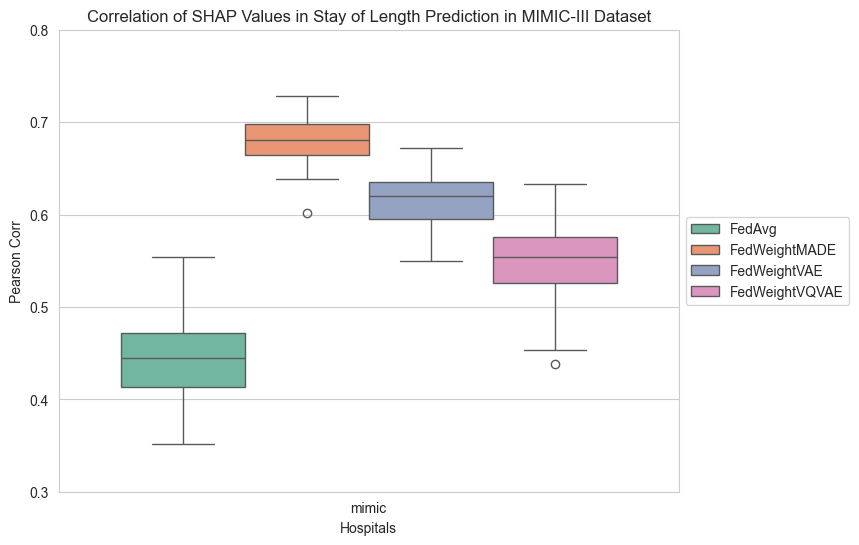

In [23]:
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.utils import resample

columns = ['Target', 'Algorithm', 'Pearson Corr']
df = pd.DataFrame(columns=columns)

total_seeds = 100
resampled_samples = 100

# Stay of length
data_length_mimic = len(length_shap_values_mimic_unweighted)

total_length_shap_values_mimic_unweighted_correlation = []
total_length_shap_values_mimic_made_correlation = []
total_length_shap_values_mimic_vae_correlation = []
total_length_shap_values_mimic_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_mimic = resample(np.arange(data_length_mimic), n_samples=resampled_samples)
    length_shap_values_mimic_unweighted_sum = np.sum(length_shap_values_mimic_unweighted[resampled_ids_mimic], axis=0)
    length_shap_values_mimic_made_sum = np.sum(length_shap_values_mimic_made[resampled_ids_mimic], axis=0)
    length_shap_values_mimic_vae_sum = np.sum(length_shap_values_mimic_vae[resampled_ids_mimic], axis=0)
    length_shap_values_mimic_vqvae_sum = np.sum(length_shap_values_mimic_vqvae[resampled_ids_mimic], axis=0)
    length_shap_values_mimic_central_sum = np.sum(length_shap_values_mimic_central[resampled_ids_mimic], axis=0)

    length_shap_values_mimic_unweighted_correlation, _ = pearsonr(length_shap_values_mimic_unweighted_sum, length_shap_values_mimic_central_sum)
    length_shap_values_mimic_made_correlation, _ = pearsonr(length_shap_values_mimic_made_sum, length_shap_values_mimic_central_sum)
    length_shap_values_mimic_vae_correlation, _ = pearsonr(length_shap_values_mimic_vae_sum, length_shap_values_mimic_central_sum)
    length_shap_values_mimic_vqvae_correlation, _ = pearsonr(length_shap_values_mimic_vqvae_sum, length_shap_values_mimic_central_sum)

    total_length_shap_values_mimic_unweighted_correlation.append(length_shap_values_mimic_unweighted_correlation)
    total_length_shap_values_mimic_made_correlation.append(length_shap_values_mimic_made_correlation)
    total_length_shap_values_mimic_vae_correlation.append(length_shap_values_mimic_vae_correlation)
    total_length_shap_values_mimic_vqvae_correlation.append(length_shap_values_mimic_vqvae_correlation)

df_mimic_unweighted = create_df("Length", "mimic", "FedAvg", total_length_shap_values_mimic_unweighted_correlation, resampled_samples)
df_mimic_made = create_df("Length", "mimic", "FedWeightMADE", total_length_shap_values_mimic_made_correlation, resampled_samples)
df_mimic_vae = create_df("Length", "mimic", "FedWeightVAE", total_length_shap_values_mimic_vae_correlation, resampled_samples)
df_mimic_vqvae = create_df("Length", "mimic", "FedWeightVQVAE", total_length_shap_values_mimic_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_mimic_unweighted], ignore_index=True)
df = pd.concat([df, df_mimic_made], ignore_index=True)
df = pd.concat([df, df_mimic_vae], ignore_index=True)
df = pd.concat([df, df_mimic_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("mimic_p_value:")

_, total_length_mimic_unweighted_p_value = ranksums(total_length_shap_values_mimic_unweighted_correlation, total_length_shap_values_mimic_vae_correlation)
print(f"total_length_mimic_unweighted_p_value: {total_length_mimic_unweighted_p_value}")

_, total_length_mimic_vqvae_p_value = ranksums(total_length_shap_values_mimic_unweighted_correlation, total_length_shap_values_mimic_vqvae_correlation)
print(f"total_length_mimic_vqvae_p_value: {total_length_mimic_vqvae_p_value}")

_, total_length_mimic_made_p_value = ranksums(total_length_shap_values_mimic_unweighted_correlation, total_length_shap_values_mimic_made_correlation)
print(f"total_length_mimic_made_p_value: {total_length_mimic_made_p_value}")

sns.set_palette('Set2')
plt.figure(figsize=(8, 6))
plt.title("Correlation of SHAP Values in Stay of Length Prediction in MIMIC-III Dataset")
ax = sns.boxplot(x = df['Target'],
                 y = df['Pearson Corr'],
                 hue = df['Algorithm'])
ax.set_ylabel('Pearson Corr')
ax.set_xlabel('Hospitals')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.3, 0.8)

mimic_p_value:
total_death_mimic_unweighted_p_value: 2.5239394239903128e-34
total_death_mimic_vqvae_p_value: 4.7900963420381215e-23
total_death_mimic_made_p_value: 0.022338135311368676


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


(0.64, 0.95)

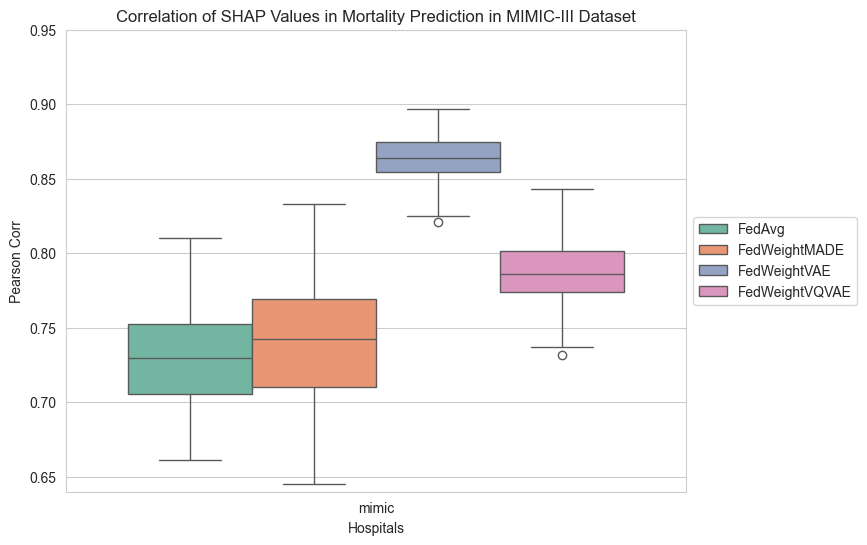

In [24]:
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.utils import resample

columns = ['Target', 'Algorithm', 'Pearson Corr']
df = pd.DataFrame(columns=columns)

total_seeds = 100
resampled_samples = 100

# Death
data_death_mimic = len(death_shap_values_mimic_unweighted)

total_death_shap_values_mimic_unweighted_correlation = []
total_death_shap_values_mimic_made_correlation = []
total_death_shap_values_mimic_vae_correlation = []
total_death_shap_values_mimic_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_mimic = resample(np.arange(data_death_mimic), n_samples=resampled_samples)
    death_shap_values_mimic_unweighted_sum = np.sum(death_shap_values_mimic_unweighted[resampled_ids_mimic], axis=0)
    death_shap_values_mimic_made_sum = np.sum(death_shap_values_mimic_made[resampled_ids_mimic], axis=0)
    death_shap_values_mimic_vae_sum = np.sum(death_shap_values_mimic_vae[resampled_ids_mimic], axis=0)
    death_shap_values_mimic_vqvae_sum = np.sum(death_shap_values_mimic_vqvae[resampled_ids_mimic], axis=0)
    death_shap_values_mimic_central_sum = np.sum(death_shap_values_mimic_central[resampled_ids_mimic], axis=0)

    death_shap_values_mimic_unweighted_correlation, _ = pearsonr(death_shap_values_mimic_unweighted_sum, death_shap_values_mimic_central_sum)
    death_shap_values_mimic_made_correlation, _ = pearsonr(death_shap_values_mimic_made_sum, death_shap_values_mimic_central_sum)
    death_shap_values_mimic_vae_correlation, _ = pearsonr(death_shap_values_mimic_vae_sum, death_shap_values_mimic_central_sum)
    death_shap_values_mimic_vqvae_correlation, _ = pearsonr(death_shap_values_mimic_vqvae_sum, death_shap_values_mimic_central_sum)

    total_death_shap_values_mimic_unweighted_correlation.append(death_shap_values_mimic_unweighted_correlation)
    total_death_shap_values_mimic_made_correlation.append(death_shap_values_mimic_made_correlation)
    total_death_shap_values_mimic_vae_correlation.append(death_shap_values_mimic_vae_correlation)
    total_death_shap_values_mimic_vqvae_correlation.append(death_shap_values_mimic_vqvae_correlation)

df_mimic_unweighted = create_df("Death", "mimic", "FedAvg", total_death_shap_values_mimic_unweighted_correlation, resampled_samples)
df_mimic_made = create_df("Death", "mimic", "FedWeightMADE", total_death_shap_values_mimic_made_correlation, resampled_samples)
df_mimic_vae = create_df("Death", "mimic", "FedWeightVAE", total_death_shap_values_mimic_vae_correlation, resampled_samples)
df_mimic_vqvae = create_df("Death", "mimic", "FedWeightVQVAE", total_death_shap_values_mimic_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_mimic_unweighted], ignore_index=True)
df = pd.concat([df, df_mimic_made], ignore_index=True)
df = pd.concat([df, df_mimic_vae], ignore_index=True)
df = pd.concat([df, df_mimic_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("mimic_p_value:")

_, total_death_mimic_unweighted_p_value = ranksums(total_death_shap_values_mimic_unweighted_correlation, total_death_shap_values_mimic_vae_correlation)
print(f"total_death_mimic_unweighted_p_value: {total_death_mimic_unweighted_p_value}")

_, total_death_mimic_vqvae_p_value = ranksums(total_death_shap_values_mimic_unweighted_correlation, total_death_shap_values_mimic_vqvae_correlation)
print(f"total_death_mimic_vqvae_p_value: {total_death_mimic_vqvae_p_value}")

_, total_death_mimic_made_p_value = ranksums(total_death_shap_values_mimic_unweighted_correlation, total_death_shap_values_mimic_made_correlation)
print(f"total_death_mimic_made_p_value: {total_death_mimic_made_p_value}")

sns.set_palette('Set2')
plt.figure(figsize=(8, 6))
plt.title("Correlation of SHAP Values in Mortality Prediction in MIMIC-III Dataset")
ax = sns.boxplot(x = df['Target'],
                 y = df['Pearson Corr'],
                 hue = df['Algorithm'])
ax.set_ylabel('Pearson Corr')
ax.set_xlabel('Hospitals')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.64, 0.95)

mimic_p_value:
total_ventilator_mimic_unweighted_p_value: 0.04084337409505855
total_ventilator_mimic_vqvae_p_value: 0.06983266125176803
total_ventilator_mimic_made_p_value: 6.95449860220244e-05


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


(0.94, 0.975)

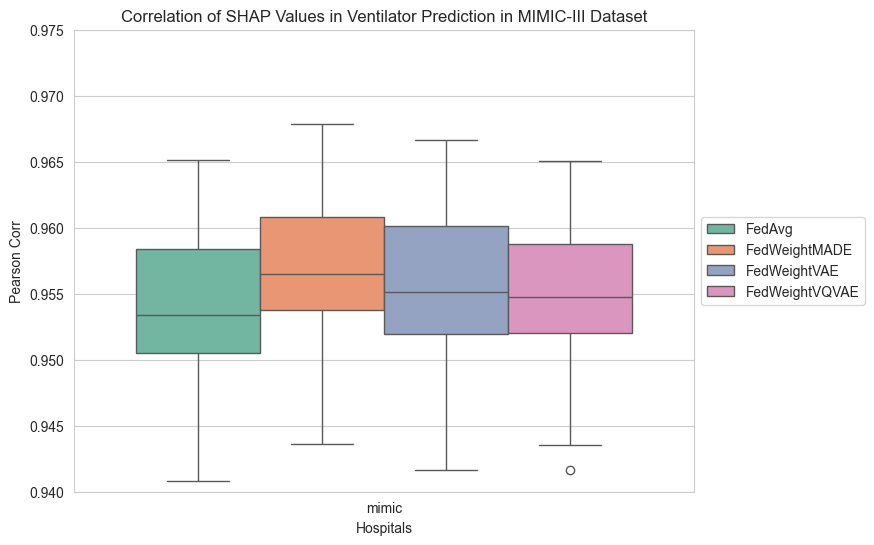

In [25]:
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.utils import resample

columns = ['Target', 'Algorithm', 'Pearson Corr']
df = pd.DataFrame(columns=columns)

total_seeds = 100
resampled_samples = 100

# Stay of ventilator
data_ventilator_mimic = len(ventilator_shap_values_mimic_unweighted)

total_ventilator_shap_values_mimic_unweighted_correlation = []
total_ventilator_shap_values_mimic_made_correlation = []
total_ventilator_shap_values_mimic_vae_correlation = []
total_ventilator_shap_values_mimic_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_mimic = resample(np.arange(data_ventilator_mimic), n_samples=resampled_samples)
    ventilator_shap_values_mimic_unweighted_sum = np.sum(ventilator_shap_values_mimic_unweighted[resampled_ids_mimic], axis=0)
    ventilator_shap_values_mimic_made_sum = np.sum(ventilator_shap_values_mimic_made[resampled_ids_mimic], axis=0)
    ventilator_shap_values_mimic_vae_sum = np.sum(ventilator_shap_values_mimic_vae[resampled_ids_mimic], axis=0)
    ventilator_shap_values_mimic_vqvae_sum = np.sum(ventilator_shap_values_mimic_vqvae[resampled_ids_mimic], axis=0)
    ventilator_shap_values_mimic_central_sum = np.sum(ventilator_shap_values_mimic_central[resampled_ids_mimic], axis=0)

    ventilator_shap_values_mimic_unweighted_correlation, _ = pearsonr(ventilator_shap_values_mimic_unweighted_sum, ventilator_shap_values_mimic_central_sum)
    ventilator_shap_values_mimic_made_correlation, _ = pearsonr(ventilator_shap_values_mimic_made_sum, ventilator_shap_values_mimic_central_sum)
    ventilator_shap_values_mimic_vae_correlation, _ = pearsonr(ventilator_shap_values_mimic_vae_sum, ventilator_shap_values_mimic_central_sum)
    ventilator_shap_values_mimic_vqvae_correlation, _ = pearsonr(ventilator_shap_values_mimic_vqvae_sum, ventilator_shap_values_mimic_central_sum)

    total_ventilator_shap_values_mimic_unweighted_correlation.append(ventilator_shap_values_mimic_unweighted_correlation)
    total_ventilator_shap_values_mimic_made_correlation.append(ventilator_shap_values_mimic_made_correlation)
    total_ventilator_shap_values_mimic_vae_correlation.append(ventilator_shap_values_mimic_vae_correlation)
    total_ventilator_shap_values_mimic_vqvae_correlation.append(ventilator_shap_values_mimic_vqvae_correlation)

df_mimic_unweighted = create_df("Ventilator", "mimic", "FedAvg", total_ventilator_shap_values_mimic_unweighted_correlation, resampled_samples)
df_mimic_made = create_df("Ventilator", "mimic", "FedWeightMADE", total_ventilator_shap_values_mimic_made_correlation, resampled_samples)
df_mimic_vae = create_df("Ventilator", "mimic", "FedWeightVAE", total_ventilator_shap_values_mimic_vae_correlation, resampled_samples)
df_mimic_vqvae = create_df("Ventilator", "mimic", "FedWeightVQVAE", total_ventilator_shap_values_mimic_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_mimic_unweighted], ignore_index=True)
df = pd.concat([df, df_mimic_made], ignore_index=True)
df = pd.concat([df, df_mimic_vae], ignore_index=True)
df = pd.concat([df, df_mimic_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("mimic_p_value:")

_, total_ventilator_mimic_unweighted_p_value = ranksums(total_ventilator_shap_values_mimic_unweighted_correlation, total_ventilator_shap_values_mimic_vae_correlation)
print(f"total_ventilator_mimic_unweighted_p_value: {total_ventilator_mimic_unweighted_p_value}")

_, total_ventilator_mimic_vqvae_p_value = ranksums(total_ventilator_shap_values_mimic_unweighted_correlation, total_ventilator_shap_values_mimic_vqvae_correlation)
print(f"total_ventilator_mimic_vqvae_p_value: {total_ventilator_mimic_vqvae_p_value}")

_, total_ventilator_mimic_made_p_value = ranksums(total_ventilator_shap_values_mimic_unweighted_correlation, total_ventilator_shap_values_mimic_made_correlation)
print(f"total_ventilator_mimic_made_p_value: {total_ventilator_mimic_made_p_value}")

sns.set_palette('Set2')
plt.figure(figsize=(8, 6))
plt.title("Correlation of SHAP Values in Ventilator Prediction in MIMIC-III Dataset")
ax = sns.boxplot(x = df['Target'],
                 y = df['Pearson Corr'],
                 hue = df['Algorithm'])
ax.set_ylabel('Pearson Corr')
ax.set_xlabel('Hospitals')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.94, 0.975)

mimic_p_value:
total_sepsis_mimic_unweighted_p_value: 5.139541269433505e-27
total_sepsis_mimic_vqvae_p_value: 2.5239394239903128e-34
total_sepsis_mimic_made_p_value: 2.5239394239903128e-34


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


(0.75, 0.95)

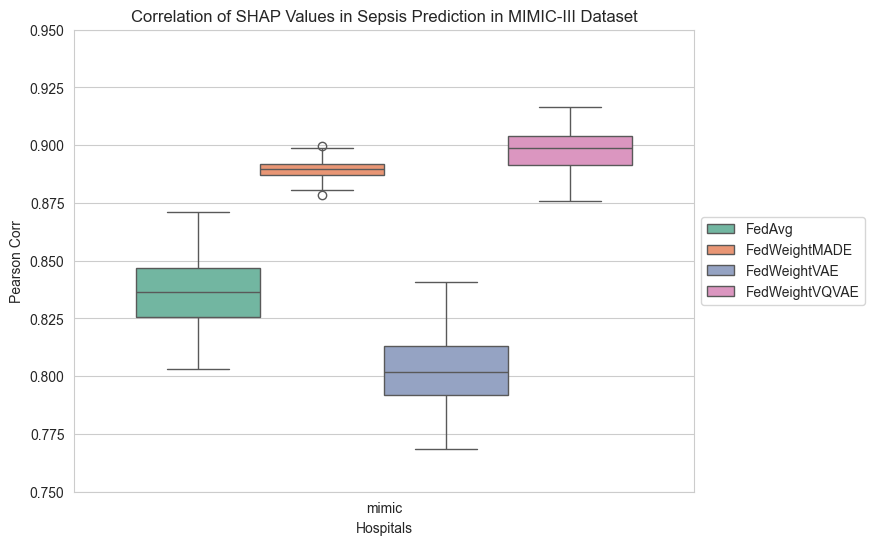

In [26]:
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.utils import resample

columns = ['Target', 'Algorithm', 'Pearson Corr']
df = pd.DataFrame(columns=columns)

total_seeds = 100
resampled_samples = 100

# Stay of sepsis
data_sepsis_mimic = len(sepsis_shap_values_mimic_unweighted)

total_sepsis_shap_values_mimic_unweighted_correlation = []
total_sepsis_shap_values_mimic_made_correlation = []
total_sepsis_shap_values_mimic_vae_correlation = []
total_sepsis_shap_values_mimic_vqvae_correlation = []

for _ in range(total_seeds):

    resampled_ids_mimic = resample(np.arange(data_sepsis_mimic), n_samples=resampled_samples)
    sepsis_shap_values_mimic_unweighted_sum = np.sum(sepsis_shap_values_mimic_unweighted[resampled_ids_mimic], axis=0)
    sepsis_shap_values_mimic_made_sum = np.sum(sepsis_shap_values_mimic_made[resampled_ids_mimic], axis=0)
    sepsis_shap_values_mimic_vae_sum = np.sum(sepsis_shap_values_mimic_vae[resampled_ids_mimic], axis=0)
    sepsis_shap_values_mimic_vqvae_sum = np.sum(sepsis_shap_values_mimic_vqvae[resampled_ids_mimic], axis=0)
    sepsis_shap_values_mimic_central_sum = np.sum(sepsis_shap_values_mimic_central[resampled_ids_mimic], axis=0)

    sepsis_shap_values_mimic_unweighted_correlation, _ = pearsonr(sepsis_shap_values_mimic_unweighted_sum, sepsis_shap_values_mimic_central_sum)
    sepsis_shap_values_mimic_made_correlation, _ = pearsonr(sepsis_shap_values_mimic_made_sum, sepsis_shap_values_mimic_central_sum)
    sepsis_shap_values_mimic_vae_correlation, _ = pearsonr(sepsis_shap_values_mimic_vae_sum, sepsis_shap_values_mimic_central_sum)
    sepsis_shap_values_mimic_vqvae_correlation, _ = pearsonr(sepsis_shap_values_mimic_vqvae_sum, sepsis_shap_values_mimic_central_sum)

    total_sepsis_shap_values_mimic_unweighted_correlation.append(sepsis_shap_values_mimic_unweighted_correlation)
    total_sepsis_shap_values_mimic_made_correlation.append(sepsis_shap_values_mimic_made_correlation)
    total_sepsis_shap_values_mimic_vae_correlation.append(sepsis_shap_values_mimic_vae_correlation)
    total_sepsis_shap_values_mimic_vqvae_correlation.append(sepsis_shap_values_mimic_vqvae_correlation)

df_mimic_unweighted = create_df("Sepsis", "mimic", "FedAvg", total_sepsis_shap_values_mimic_unweighted_correlation, resampled_samples)
df_mimic_made = create_df("Sepsis", "mimic", "FedWeightMADE", total_sepsis_shap_values_mimic_made_correlation, resampled_samples)
df_mimic_vae = create_df("Sepsis", "mimic", "FedWeightVAE", total_sepsis_shap_values_mimic_vae_correlation, resampled_samples)
df_mimic_vqvae = create_df("Sepsis", "mimic", "FedWeightVQVAE", total_sepsis_shap_values_mimic_vqvae_correlation, resampled_samples)

df = pd.concat([df, df_mimic_unweighted], ignore_index=True)
df = pd.concat([df, df_mimic_made], ignore_index=True)
df = pd.concat([df, df_mimic_vae], ignore_index=True)
df = pd.concat([df, df_mimic_vqvae], ignore_index=True)

from scipy.stats import ranksums

print("mimic_p_value:")

_, total_sepsis_mimic_unweighted_p_value = ranksums(total_sepsis_shap_values_mimic_unweighted_correlation, total_sepsis_shap_values_mimic_vae_correlation)
print(f"total_sepsis_mimic_unweighted_p_value: {total_sepsis_mimic_unweighted_p_value}")

_, total_sepsis_mimic_vqvae_p_value = ranksums(total_sepsis_shap_values_mimic_unweighted_correlation, total_sepsis_shap_values_mimic_vqvae_correlation)
print(f"total_sepsis_mimic_vqvae_p_value: {total_sepsis_mimic_vqvae_p_value}")

_, total_sepsis_mimic_made_p_value = ranksums(total_sepsis_shap_values_mimic_unweighted_correlation, total_sepsis_shap_values_mimic_made_correlation)
print(f"total_sepsis_mimic_made_p_value: {total_sepsis_mimic_made_p_value}")

sns.set_palette('Set2')
plt.figure(figsize=(8, 6))
plt.title("Correlation of SHAP Values in Sepsis Prediction in MIMIC-III Dataset")
ax = sns.boxplot(x = df['Target'],
                 y = df['Pearson Corr'],
                 hue = df['Algorithm'])
ax.set_ylabel('Pearson Corr')
ax.set_xlabel('Hospitals')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.75, 0.95)